In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import gc #Garbage Collector interface
sns.set_style("whitegrid");
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle as pkl #Wrap object to use later
import tqdm as tqdm # make your loops show a smart progress meter
import plotly.graph_objects as go
import missingno
from plotly.subplots import make_subplots
from tqdm import tqdm

## application : train | test

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

In [ ]:
app_train=pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/application_train.csv")
app_test=pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/application_test.csv")

**We are going to start by analyzing the App_train which is already labelized**



In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
app_train.shape

(307511, 122)

In [ ]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [ ]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
app_test.shape

(48744, 121)

In [ ]:
#sum of each Type of contract
app_train['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

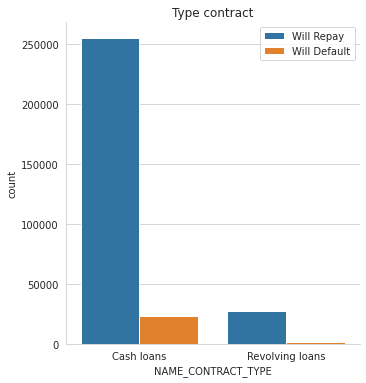

In [ ]:
#visualition de la distribution
ax=sns.catplot(x='NAME_CONTRACT_TYPE', kind="count",hue='TARGET', data=app_train,legend=False)
plt.title('Type contract')
plt.legend(labels=['Will Repay', 'Will Default'])


#Defaulters target : 1
#non defautlers target : 0 => ont pu repayer their loans

- Check the if the data is balanced or imbalanced ?
- Any dataset with an unequal class distribution is technically imbalanced. However, a dataset is said to be imbalanced when there is a significant, or in some cases extreme, disproportion among the number of examples of each class of the problem.

In [ ]:
#The target variable
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Text(0.5, 1.0, 'Target count')

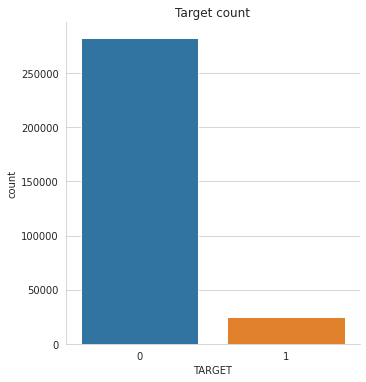

In [ ]:
#visualition de la distribution
ax=sns.catplot(x="TARGET", kind="count", data=app_train)
plt.title('Target count')

#Defaulters target : 1
#non defautlers target : 0 => ont pu repayer their loans

In [ ]:
target_distribution = app_train.TARGET.value_counts()
labels = ['Non-Defaulter', 'Defaulter']

fig = go.Figure(data = [
        go.Pie(values = target_distribution, labels = labels, textinfo = 'label+percent+value' , pull = [0,0.04])], 
         layout = go.Layout(title = 'Distribution of Target Variable'))

fig.show()

**Observations and Conclusions:**
- From the distribution of Target variable, we notice the Data is Imbalanced. There are only 8.07% of the total loans that had actually been Defaulted. This means that Defaulters is the minority class.

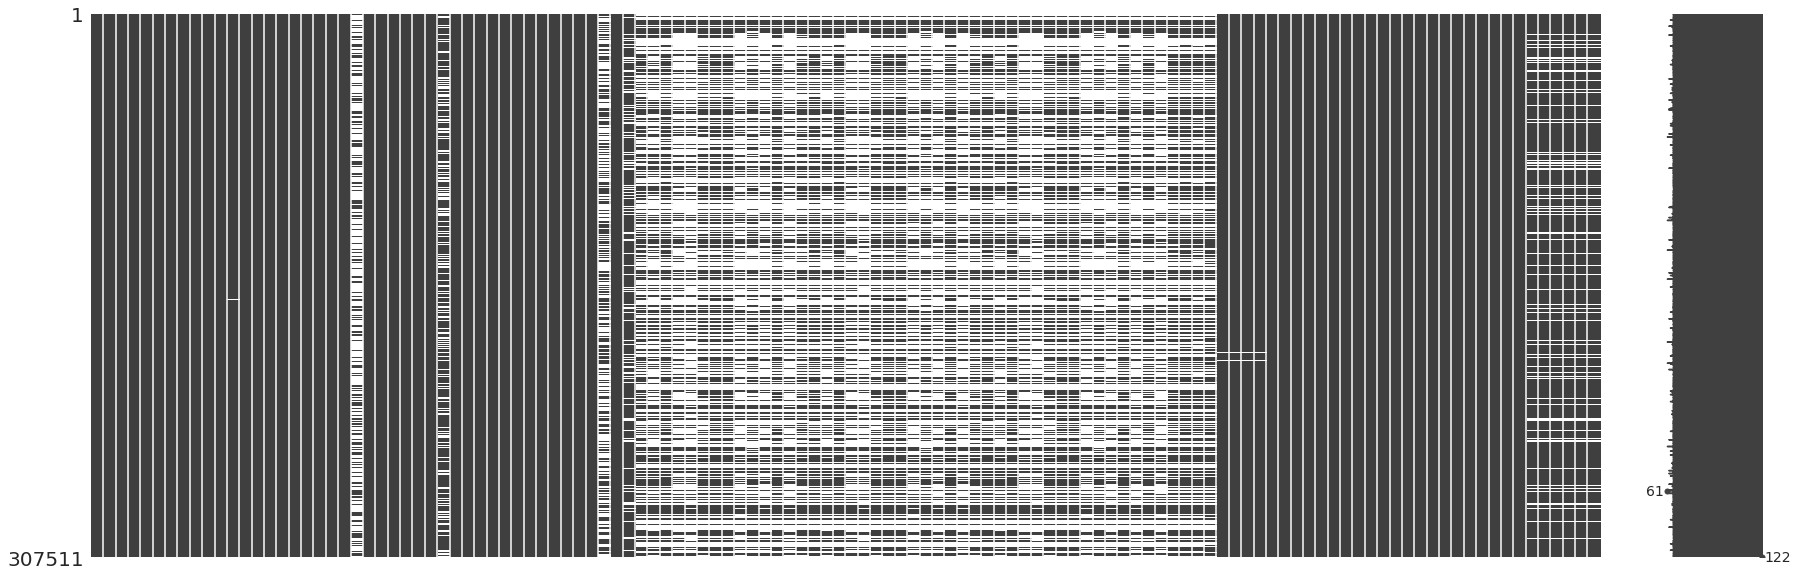

In [ ]:
#to test if there is any missing values \ figsize : the figure in inches
# we are going to use a librairy defined to tackle this issue
missingno.matrix(app_train, figsize = (30,10))

- The library for managing missing values got us a matrix and a plot
that can not be read since the dataset is very large, so we changed to work with a function that extract that and plot it 

In [ ]:
def missing_values(df):
    '''
    Get the missing values percentage in decending order
    '''
    mis_val=df.isnull().sum()
    mis_val_percent =100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print (" this Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [ ]:
#extract the column with the missing values
missing_values_data=missing_values(app_train)

 this Dataframe has 122 columns.
There are 67 columns that have missing values.


In [ ]:
#le nom des colonnes ayant des valeurs nulles
missing_values_data.head(7)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4


In [ ]:
#get all the columns from app_train with no missing data
#useful to work with

print("The columns that do not have missing values: ")
not_missing_columns=list(set(app_train.columns)-set(missing_values_data.index))
not_missing_columns

The columns that do not have missing values: 


['FLAG_WORK_PHONE',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_8',
 'SK_ID_CURR',
 'CODE_GENDER',
 'REG_REGION_NOT_WORK_REGION',
 'FLAG_OWN_CAR',
 'NAME_HOUSING_TYPE',
 'FLAG_DOCUMENT_20',
 'HOUR_APPR_PROCESS_START',
 'CNT_CHILDREN',
 'FLAG_OWN_REALTY',
 'AMT_CREDIT',
 'LIVE_CITY_NOT_WORK_CITY',
 'NAME_FAMILY_STATUS',
 'TARGET',
 'FLAG_EMP_PHONE',
 'REGION_POPULATION_RELATIVE',
 'REGION_RATING_CLIENT',
 'DAYS_ID_PUBLISH',
 'NAME_INCOME_TYPE',
 'LIVE_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_12',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_11',
 'FLAG_PHONE',
 'FLAG_DOCUMENT_5',
 'REG_REGION_NOT_LIVE_REGION',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'FLAG_DOCUMENT_6',
 'REG_CITY_NOT_WORK_CITY',
 'DAYS_REGISTRATION',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_17',
 'FLAG_MOBIL',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_DOCUMENT_19',
 'REGION_RATING_CLIENT_W_CITY',
 'FLAG_DOCUMENT_4',
 'NAME_EDUCATION_T

In [ ]:
#column count based on data type
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [ ]:
#column count based on data type for columns that do not have any missing data 
app_train[not_missing_columns].dtypes.value_counts()

int64      41
object     10
float64     4
dtype: int64

In [ ]:
#column count based on data type for columns that do have  missing data 
app_train[missing_values_data.index].dtypes.value_counts()

float64    61
object      6
dtype: int64

In [ ]:
app_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Amount credit (Credit amount of the loan)

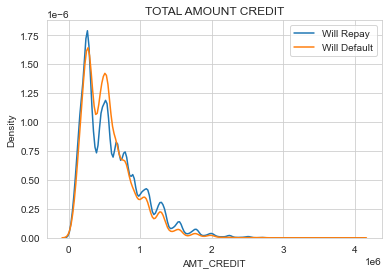

In [ ]:
plt.title('TOTAL AMOUNT CREDIT')

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_CREDIT'] , label ='Will Repay')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_CREDIT'] , label ='Will Default')
plt.legend()


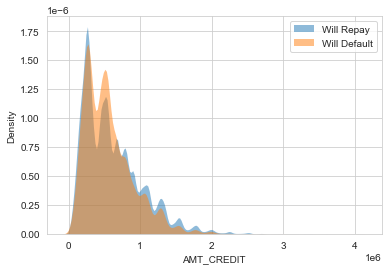

In [ ]:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_CREDIT'] , label ='Will Repay',fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_CREDIT'] , label ='Will Default',fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,)
plt.legend()



***Conclusion***
- It is clear that the data is highly overlapping between the people who are able to pay loan on time and the people who had difficulty in paying loan back.

### Amount Income Total (Income of the client)

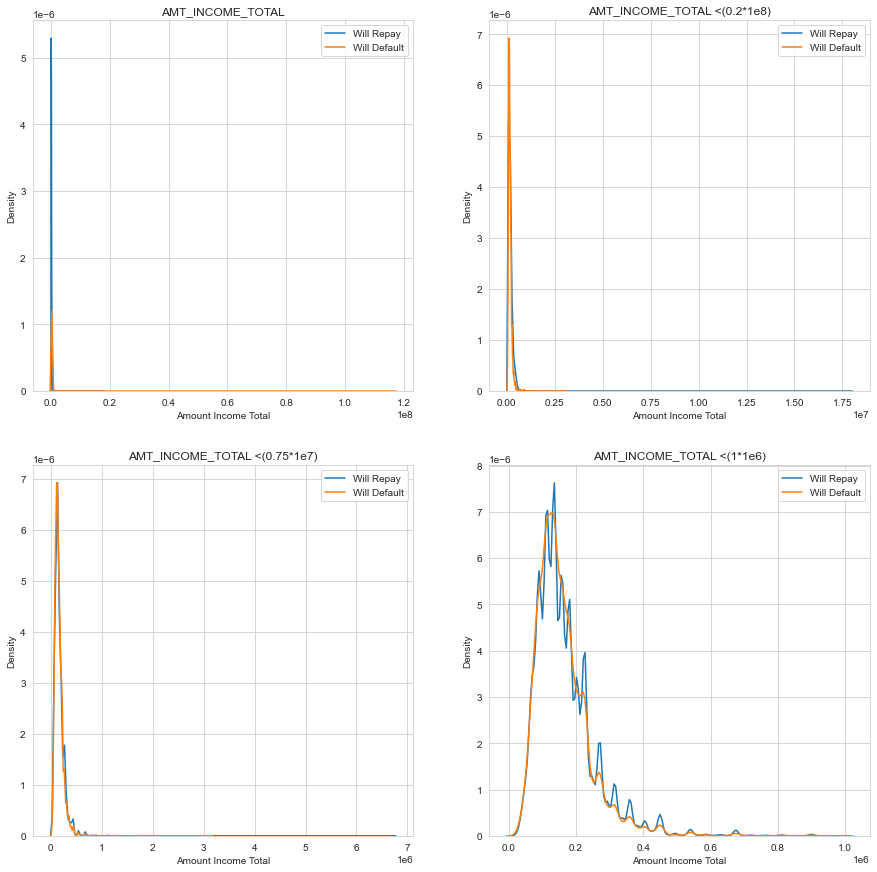

In [ ]:
#AMT_INCOME_TOTAL is the income of the client.
#we need to do an analysis on the total income for both clients 
#clients who will default and clients who will not


fig,axes=plt.subplots(2,2,figsize=(15,15))

axes[0,0].title.set_text('AMT_INCOME_TOTAL')
axes[0,0].set_xlabel('Amount Income Total')
axes[0,0].set_ylabel('Density')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_INCOME_TOTAL'] , label = 'Will Repay',ax=axes[0,0])
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_INCOME_TOTAL'] , label = 'Will Default',ax=axes[0,0])
axes[0,0].legend()

axes[0,1].title.set_text('AMT_INCOME_TOTAL <(0.2*1e8)')
axes[0,1].set_xlabel('Amount Income Total')
axes[0,1].set_ylabel('Density')
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 0) & (app_train['AMT_INCOME_TOTAL']<(0.2*1e8)), 'AMT_INCOME_TOTAL'] , label = 'Will Repay',ax=axes[0,1])
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 1) & (app_train['AMT_INCOME_TOTAL']<(0.2*1e8)), 'AMT_INCOME_TOTAL'] , label = 'Will Default',ax=axes[0,1])
axes[0,1].legend()


axes[1,0].title.set_text('AMT_INCOME_TOTAL <(0.75*1e7)')
axes[1,0].set_xlabel('Amount Income Total')
axes[1,0].set_ylabel('Density')
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 0) & (app_train['AMT_INCOME_TOTAL']<(0.75*1e7)), 'AMT_INCOME_TOTAL'] , label = 'Will Repay',ax=axes[1,0])
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 1) & (app_train['AMT_INCOME_TOTAL']<(0.75*1e7)), 'AMT_INCOME_TOTAL'] , label = 'Will Default',ax=axes[1,0])
axes[1,0].legend()

axes[1,1].title.set_text('AMT_INCOME_TOTAL <(1*1e6)')
axes[1,1].set_xlabel('Amount Income Total')
axes[1,1].set_ylabel('Density')
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 0) & (app_train['AMT_INCOME_TOTAL']<(1*1e6)), 'AMT_INCOME_TOTAL'] , label = 'Will Repay',ax=axes[1,1])
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 1) & (app_train['AMT_INCOME_TOTAL']<(1*1e6)), 'AMT_INCOME_TOTAL'] , label = 'Will Default',ax=axes[1,1])
axes[1,1].legend()

In [ ]:
app_train[app_train['AMT_INCOME_TOTAL']>(0.2*1e8)] #outlier

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
12840,114967,1,Cash loans,F,N,Y,1,117000000.0,562491.0,26194.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## Ploting the days employed (In years)

In [ ]:
#Dealing with anomalies since the days are way much bigger
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

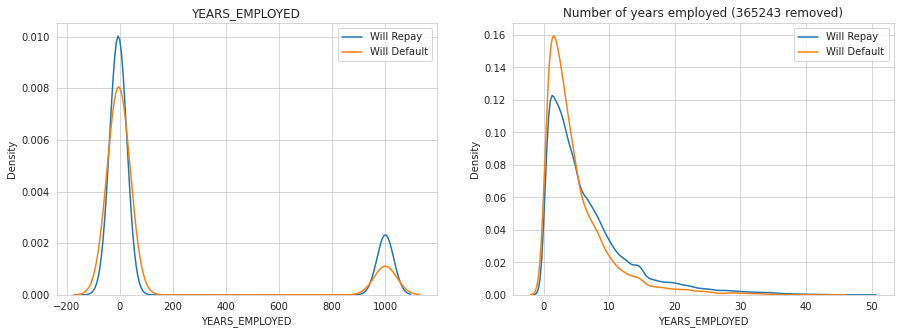

In [ ]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15, 5))

app_train['YEARS_EMPLOYED']=(app_train['DAYS_EMPLOYED'])/365

axes[0].title.set_text('YEARS_EMPLOYED')
axes[0].set_xlabel('YEARS_EMPLOYED')
axes[0].set_ylabel('Density')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'YEARS_EMPLOYED'] , label = 'Will Repay',ax=axes[0])
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'YEARS_EMPLOYED'] , label = 'Will Default',ax=axes[0])
axes[0].legend()

#Replacing the outlier with np.nan
app_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

app_train['YEARS_EMPLOYED']=(-app_train['DAYS_EMPLOYED'])/365

axes[1].title.set_text('Number of years employed (365243 removed)')
axes[1].set_xlabel('YEARS_EMPLOYED')
axes[1].set_ylabel('Density')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'YEARS_EMPLOYED'] , label = 'Will Repay',ax=axes[1])
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'YEARS_EMPLOYED'] , label = 'Will Default',ax=axes[1])
axes[1].legend()

## Ploting the days_birth (In years )| AGE

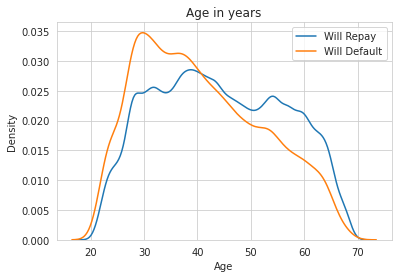

In [ ]:
# to know the range age of people who goes for loans
app_train['AGE_YEARS']=(-app_train['DAYS_BIRTH'])/365
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AGE_YEARS'] , label = 'Will Repay')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AGE_YEARS'] , label='Will Default')
plt.title('Age in years')
plt.ylabel('Density')
plt.xlabel('Age')
plt.legend()

## Documents ANALYSIS | NUMBER of documents submitted 

- we know that when applying for a loan , a lot of documents should be presented
- Lets see the number of document submitted by a person who was able to pay loan and who wasn't

In [ ]:
#on rajoute une colonne qui regroupe tous les documents to app_train
app_train['DOCUMNNET_COUNT']=(app_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]==1).sum(axis=1)

In [ ]:
#tester la colonne with no defaulters
app_train_0=app_train[app_train['TARGET']==0]
app_train_0.head(7)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_EMPLOYED,AGE_YEARS,DOCUMNNET_COUNT
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.254795,45.931507,1
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.616438,52.180822,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,8.326027,52.068493,1
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.323288,54.608219,1
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588.0,-4970.0,-477,NaN,1,1,1,1,1,0,Laborers,2.0,2,2,WEDNESDAY,16,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2536.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,4.350685,46.413699,1
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130.0,-1213.0,-619,17.0,1,1,0,1,1,0,Accountants,3.0,2,2,SUNDAY,16,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-1562.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,8.575342,37.747945,2
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.003122,-18850,-449.0,-4597.0,-2379,8.0,1,1,1,1,0,0,Managers,2.0,3,3,MONDAY,16,0,0,

In [ ]:
#Documents submitted for client who IS NOT a DEFAULTER
app_train_0=app_train[app_train['TARGET']==0]
app_train_0['DOCUMNNET_COUNT'].value_counts().reset_index()

#outcome : how many people submited 1 document = total
# un seul doc = 247239
#deux doc = 7983

,index,DOCUMNNET_COUNT
0,1,247239
1,0,27917
2,2,7383
3,3,147


In [ ]:
#will default
app_train_0=app_train[app_train['TARGET']==1]
app_train_0.head(7)
#voir last column

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_EMPLOYED,AGE_YEARS,DOCUMNNET_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.745205,25.920548,1
26,100031,1,Cash loans,F,N,Y,0,112500.0,979992.0,27076.5,702000.0,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,0.018029,-18724,-2628.0,-6573.0,-1827,NaN,1,1,0,1,0,0,Cooking staff,1.0,3,2,MONDAY,9,0,0,0,0,0,0,...,0.0000,NaN,block of flats,0.0085,Wooden,Yes,10.0,1.0,10.0,0.0,-161.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0,7.200000,51.298630,2
40,100047,1,Cash loans,M,N,Y,0,202500.0,1193580.0,35028.0,855000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.025164,-17482,-1262.0,-1182.0,-1029,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,TUESDAY,9,0,0,0,0,0,0,...,0.0079,org spec account,block of flats,0.1463,"Stone, brick",No,0.0,0.0,0.0,0.0,-1075.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,4.0,3.457534,47.895890,1
42,100049,1,Cash loans,F,N,N,0,135000.0,288873.0,16258.5,238500.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.007305,-13384,-3597.0,-45.0,-4409,NaN,1,1,1,1,1,0,Sales staff,2.0,3,3,THURSDAY,11,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-1480.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,9.854795,36.668493,1
81,100096,1,Cash loans,F,N,Y,0,81000.0,252000.0,14593.5,252000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.028663,-24794,NaN,-5391.0,-4199,NaN,1,0,0,1,0,0,NaN,2.0,2,2,THURSDAY,10,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,67.928767,1
94,100112,1,Cash loans,M,Y,Y,0,315000.0,953460.0,64107.0,900000.0,Family,Commercial associate,Incomplete higher,Single / not married,With parents,0.030755,-10199,-2015.0,-4802.0,-1038,2.0,1,1,0,1,0,0,NaN,1.0,2,2,SUNDAY,13,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-591.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,5.520548,27.942466,1
110,100130,1,Cash loans,F,N,Y,1,157500.0,723996.0,30802.5,585000.0,Unaccompanied,Commercial associate,Incomplete higher,Separated,House / apartment,0.007274,-10526,-267

In [ ]:
app_train_0['DOCUMNNET_COUNT']==3

0         False
26        False
40        False
42        False
81        False
          ...  
307448    False
307475    False
307481    False
307489    False
307509    False
Name: DOCUMNNET_COUNT, Length: 24825, dtype: bool

In [ ]:
#Documents submitted for client who IS a DEFAULTER
app_train_0=app_train[app_train['TARGET']==1]
app_train_0['DOCUMNNET_COUNT'].value_counts()

#A revoir comprendre ce resultat
#une seule personne a presenter 4 doc and still a defaulter

1    22817
0     1632
2      359
3       16
4        1
Name: DOCUMNNET_COUNT, dtype: int64

In [ ]:
#providing the documents for the total of clients
(app_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]==1).sum(axis=0)

FLAG_DOCUMENT_2         13
FLAG_DOCUMENT_3     218340
FLAG_DOCUMENT_4         25
FLAG_DOCUMENT_5       4648
FLAG_DOCUMENT_6      27078
FLAG_DOCUMENT_7         59
FLAG_DOCUMENT_8      25024
FLAG_DOCUMENT_9       1198
FLAG_DOCUMENT_10         7
FLAG_DOCUMENT_11      1203
FLAG_DOCUMENT_12         2
FLAG_DOCUMENT_13      1084
FLAG_DOCUMENT_14       903
FLAG_DOCUMENT_15       372
FLAG_DOCUMENT_16      3053
FLAG_DOCUMENT_17        82
FLAG_DOCUMENT_18      2500
FLAG_DOCUMENT_19       183
FLAG_DOCUMENT_20       156
FLAG_DOCUMENT_21       103
dtype: int64

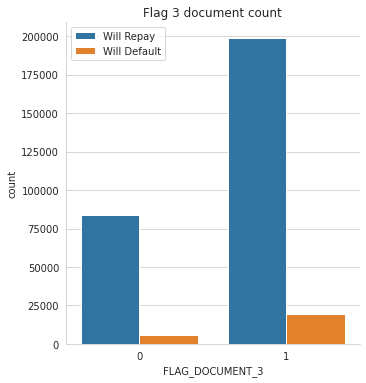

In [ ]:
sns.catplot(x="FLAG_DOCUMENT_3", kind="count",hue='TARGET', data=app_train,legend=False)
plt.title('Flag 3 document count')
plt.legend(labels=['Will Repay', 'Will Default'])

# 0= submit the doc
# 1 = didn't submit the doc

Total Number of unique categories of FLAG_DOCUMENT_3 = 2


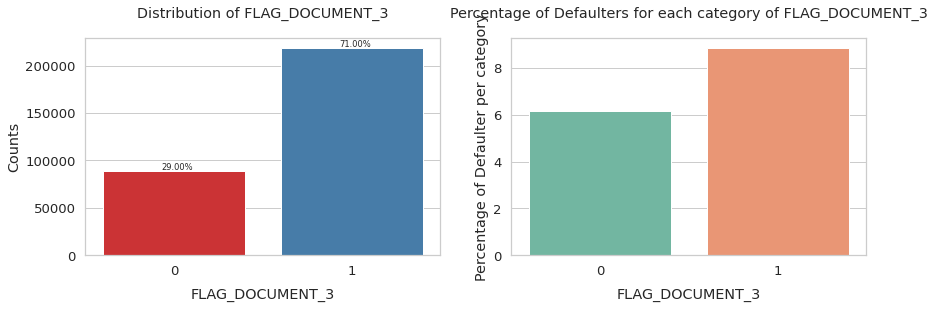

In [ ]:
plot_categorical_variables_bar(app_train, column_name = 'FLAG_DOCUMENT_3', figsize = (14, 4), horizontal_adjust = 0.33)

## Gender column

In [ ]:
app_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [ ]:
app_test['CODE_GENDER'].unique()

array(['F', 'M'], dtype=object)

### Conclusion
- We have to removed the CODE_GENDER value 'XNA' because it wasn't present in test data and hence not helpful.

In [ ]:
#Replacing the outlier with np.nan
app_train["CODE_GENDER"].replace({'XNA': np.nan}, inplace = True)

In [ ]:
app_train['CODE_GENDER'].unique()

array(['M', 'F', nan], dtype=object)

In [ ]:
app_train['CODE_GENDER'].dropna(how=np.nan)

0         M
1         F
2         M
3         F
4         M
         ..
307506    M
307507    F
307508    F
307509    F
307510    F
Name: CODE_GENDER, Length: 307507, dtype: object

In [ ]:
#a revoir
app_train['CODE_GENDER'].unique()
app_train['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

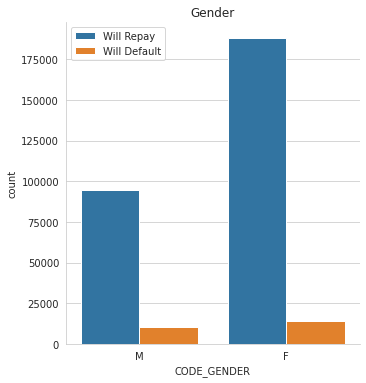

In [ ]:
sns.catplot(x="CODE_GENDER", kind="count",hue='TARGET', data=app_train,legend=False)
plt.title('Gender')
plt.legend(labels=['Will Repay', 'Will Default'])


### Conclusion
- We can conclude that women apply to get more loans than men

## Organization | WORK

In [ ]:
app_train['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

In [ ]:
app_test['ORGANIZATION_TYPE'].unique()

array(['Kindergarten', 'Self-employed', 'Transport: type 3',
       'Business Entity Type 3', 'Government', 'Industry: type 9',
       'School', 'Trade: type 2', 'XNA', 'Services', 'Bank',
       'Industry: type 3', 'Other', 'Trade: type 6', 'Industry: type 12',
       'Trade: type 7', 'Postal', 'Medicine', 'Housing',
       'Business Entity Type 2', 'Construction', 'Military',
       'Industry: type 4', 'Trade: type 3', 'Legal Services', 'Security',
       'Industry: type 11', 'University', 'Business Entity Type 1',
       'Agriculture', 'Security Ministries', 'Transport: type 2',
       'Industry: type 7', 'Transport: type 4', 'Telecom', 'Emergency',
       'Police', 'Industry: type 1', 'Transport: type 1', 'Electricity',
       'Industry: type 5', 'Hotel', 'Restaurant', 'Advertising', 'Mobile',
       'Trade: type 1', 'Industry: type 8', 'Realtor', 'Cleaning',
       'Industry: type 2', 'Trade: type 4', 'Industry: type 6', 'Culture',
       'Insurance', 'Religion', 'Industry: type 1

## OCCUPATION

***This feature tells about the type of Occupation that the client has. This can be a very important feature which could describe the Defaulting Characteristics of a client. Let us see the plots for them.***

----------------------------------------------------------------------------------------------------
The unique categories of 'OCCUPATION_TYPE' are:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of OCCUPATION_TYPE = 19


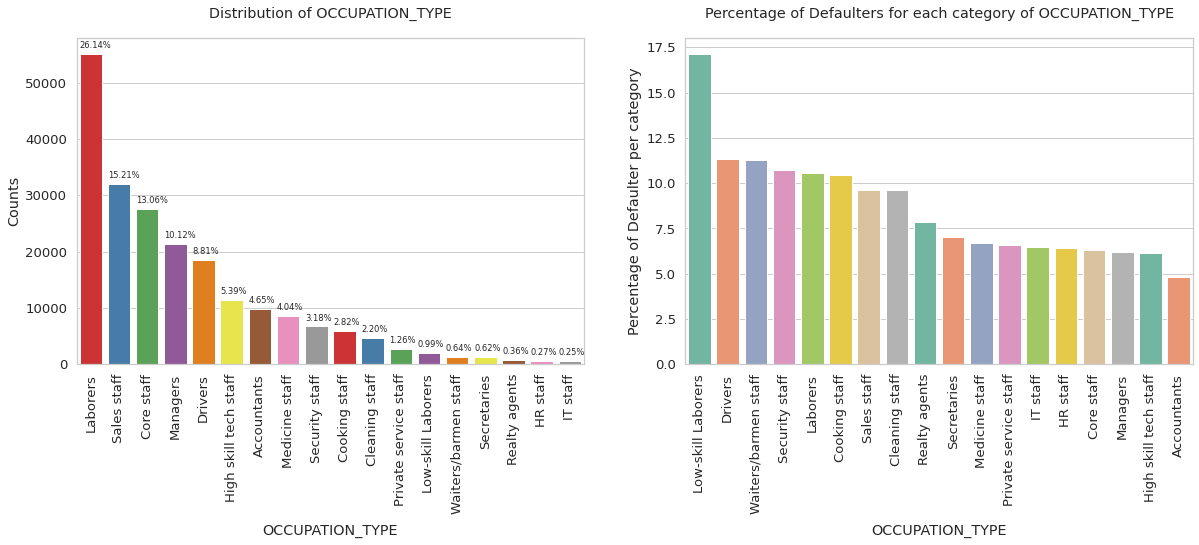

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'OCCUPATION_TYPE'
print_unique_categories(app_train, 'OCCUPATION_TYPE')

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(app_train, column_name = 'OCCUPATION_TYPE', figsize = (20,6), rotation = 90)
print('-'*100)

**Which category of occupants repay on time and are better clients for company to lend money?**

Text(0.5, 0, 'Occupation Type')

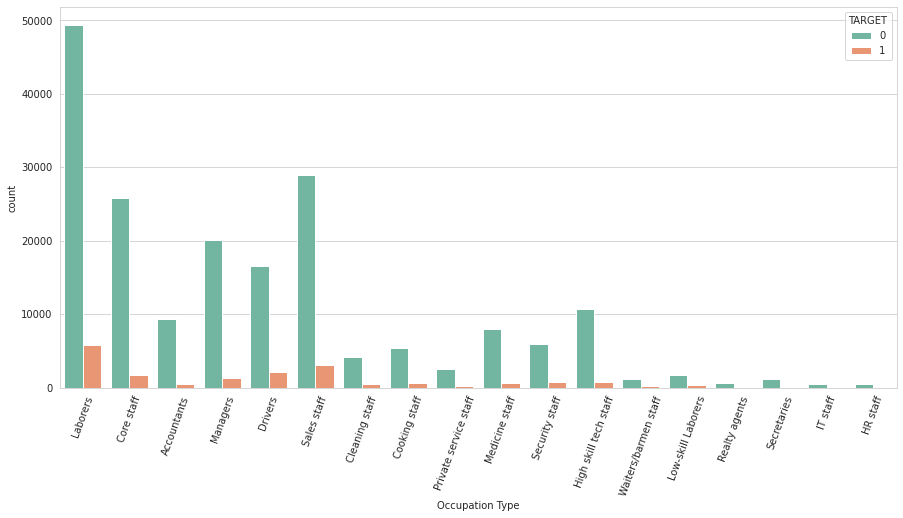

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='OCCUPATION_TYPE',hue='TARGET',data=app_train,palette="Set2")
plt.xticks(rotation=70)
plt.xlabel("Occupation Type")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

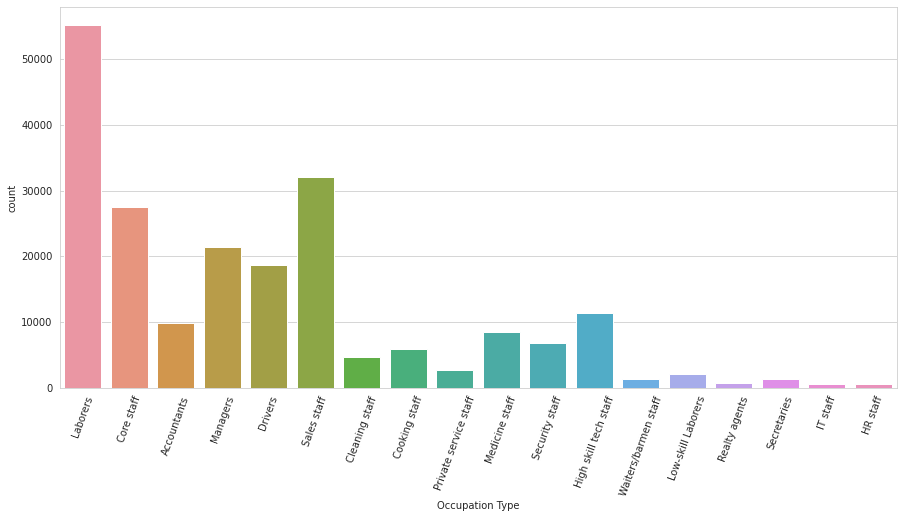

In [ ]:
#The major borrowers
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='OCCUPATION_TYPE',data=app_train)
plt.xlabel("Occupation Type")
plt.xticks(rotation=70)

Text(0, 0.5, 'Average Annual family income')

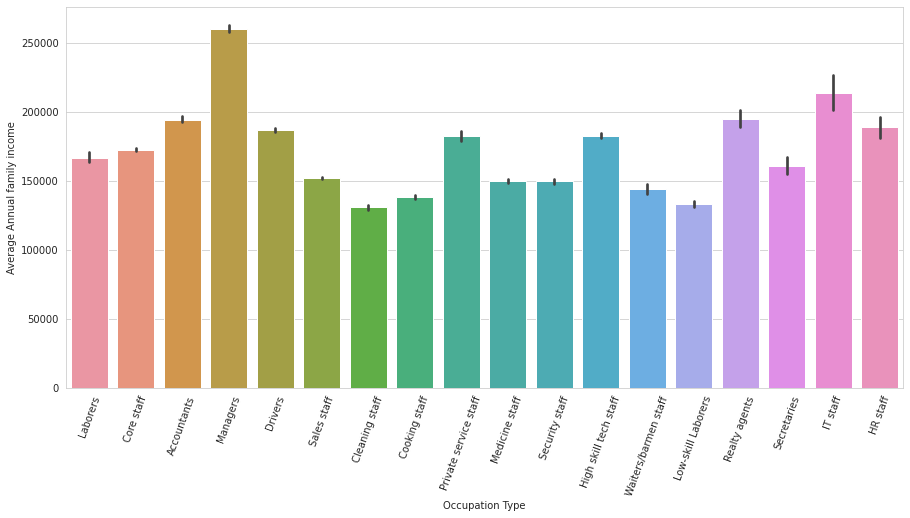

In [ ]:
#How economically stable are clients? Who are the most and least stable
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(x='OCCUPATION_TYPE',y='AMT_INCOME_TOTAL',data=app_train)
plt.xticks(rotation=70)
plt.xlabel("Occupation Type")
plt.ylabel("Average Annual family income")

Managers are the most earning borrowers while cleaning staff are the least earning borrowers - Based on the annual family income.

# EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 (Normalized score from external data source)

**There are three EXT_SOURCES columns, which contain values between 0 and 1. They are normalized scores from different sources**

In [ ]:
app_train.head(7)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_EMPLOYED,AGE_YEARS,DOCUMNNET_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.745205,25.920548,1
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.254795,45.931507,1
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.616438,52.180822,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,8.326027,52.068493,1
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.323288,54.608219,1
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588.0,-4970.0,-477,NaN,1,1,1,1,1,0,Laborers,2.0,2,2,WEDNESDAY,16,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2536.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,4.350685,46.413699,1
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130.0,-1213.

In [ ]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)

In [ ]:
categorical_columns = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + app_train.dtypes[
                                    app_train.dtypes == 'object'].index.tolist()

In [ ]:
app_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [ ]:
app_train.select_dtypes(include=['int64'])

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,-9461,-637,-2120,1,1,0,1,1,0,2,2,10,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,-16765,-1188,-291,1,1,0,1,1,0,1,1,11,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,-19046,-225,-2531,1,1,1,1,1,0,2,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,-19005,-3039,-2437,1,1,0,1,0,0,2,2,17,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,-19932,-3038,-3458,1,1,0,1,0,0,2,2,11,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,-9327,-236,-1982,1,1,0,1,0,0,1,1,15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
307507,456252,0,0,-20775,365243,-4090,1,0,0,1,1,0,2,2,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307508,456253,0,0,-14966,-7921,-5150,1,1,0,1,0,1,3,3,9,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307509,456254,1,0,-11961,-4786,-931,1,1,0,1,0,0,2,2,9,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
numerical_columns = list(app_train.select_dtypes(include=['int64']).columns)

In [ ]:
numerical_columns

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

We will plot a heatmap of the correlation of each numeric feature with respect to other features. We have excluded the column SK_ID_CURR, as it does not have any relevance. This heatmap will help us identify the highly correlated numeric features and will also help us to identify features which are highly correlated with Target Variable.

----------------------------------------------------------------------------------------------------


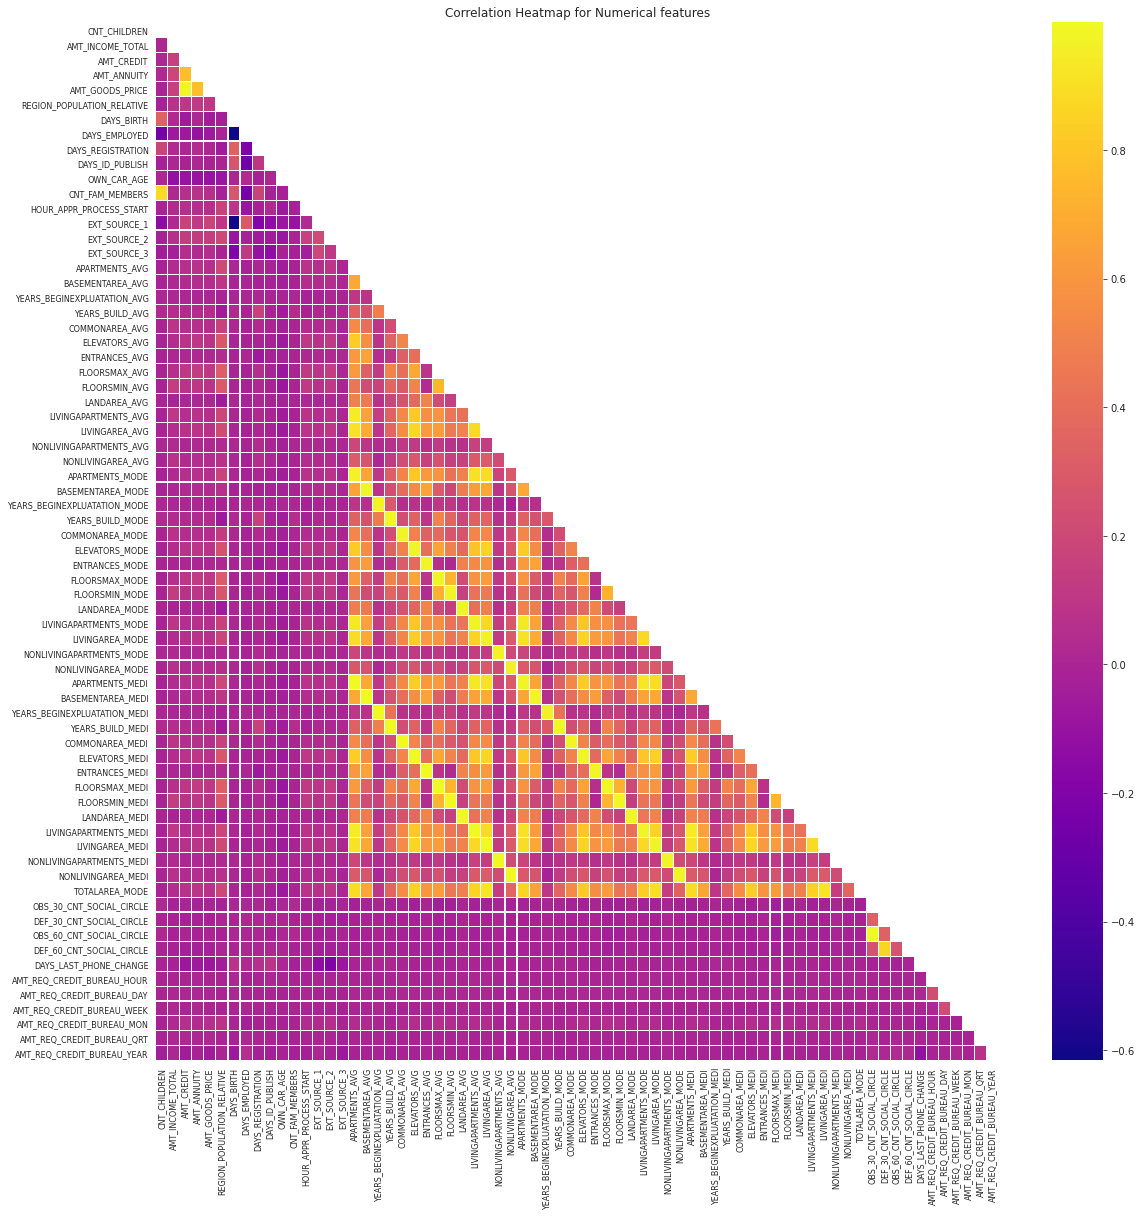

----------------------------------------------------------------------------------------------------


In [ ]:
columns_to_drop = ['SK_ID_CURR'] + list(set(categorical_columns) - set(['TARGET']))
corr_mat = correlation_matrix(app_train, columns_to_drop, figsize = (17,17), fontsize = 8, cmap = 'plasma')
corr_mat.plot_correlation_matrix()

#TO ADD HEATMAP for Categorical features

### Pair Plot ('DAYS_EMPLOYED vs DAYS_BIRTH (age) vs AMT_INCOME_TOTAL(salary) vs AMT_CREDIT vs AMT_ANNUITY')

- DAYS_EMPLOYED - How many days before the application the person started current employment
- DAYS_BIRTH - Client's age in days at the time of application
- AMT_INCOME_TOTAL - Income of the client
- AMT_CREDIT - Credit amount of the loan
- AMT_ANNUITY - Loan annuity

L'annuité constante est le remboursement annuel d'un emprunt avec les intérêts par un montant constant, qui est calculé en fonction du taux d'intérêt et de la durée de l'emprunt selon une formule mathématique.

In [ ]:
app_train.head(7)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_EMPLOYED,AGE_YEARS,DOCUMNNET_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.745205,25.920548,1
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.254795,45.931507,1
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.616438,52.180822,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,8.326027,52.068493,1
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.323288,54.608219,1
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588.0,-4970.0,-477,NaN,1,1,1,1,1,0,Laborers,2.0,2,2,WEDNESDAY,16,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2536.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,4.350685,46.413699,1
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130.0,-1213.

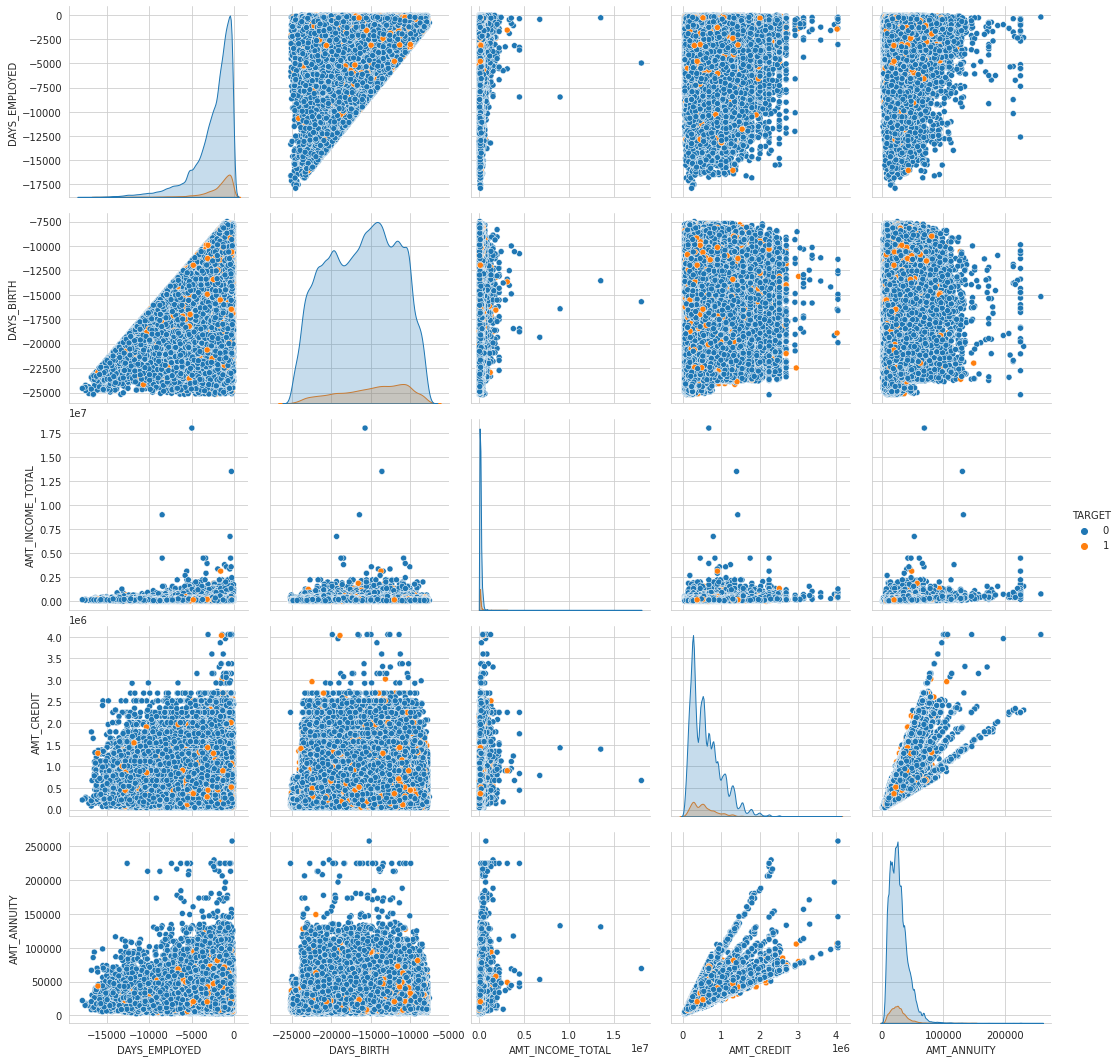

In [ ]:
# Pairplot visualizes given data to find the relationship between them where the variables can be continuous or categorical. 
#remove one outlier in AMT_INCOME_TOTAL => Already done above , voir partie salaire
# A analyser
app_train=app_train[app_train['AMT_INCOME_TOTAL']<(0.2*1e8)]
sns.pairplot(app_train, hue="TARGET", height=3,vars=['DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY']);

In [ ]:
'''
One-Hot Encoding is another popular technique for treating categorical variables.
It simply creates additional features based on the number of unique values in
the categorical feature. Every unique value in the category will be added as a
feature. One-Hot Encoding is the process of creating dummy variables.
'''
def one_hot_encoding_dataframe(df):
    '''
    one hot encoding 
    '''
    original_columns = list(df.columns)
    cat_columns=[x for x in df.columns if df[x].dtype == 'object']
    df=pd.get_dummies(df,columns=cat_columns,dummy_na= False)
    new_added_columns=list(set(df.columns).difference(set(original_columns)))
    return df,new_added_columns,df.columns

In [ ]:
def correlation_with_target_top_n(df,n):
    '''
    Calculate the correlation
    '''
    df_corr= df.corr()['TARGET'].sort_values()
    print(n,'Positive Correlations:\n', df_corr.tail(n))
    print('\n',n,' Negative Correlations:\n', df_corr.head(n))
    return df_corr


In [ ]:
#corr relation of only train data after adding new features
df_corr=correlation_with_target_top_n(app_train[app_train['TARGET'].notnull()],20)

20 Positive Correlations:
 DOCUMNNET_COUNT                0.017192
CNT_CHILDREN                   0.019179
AMT_REQ_CREDIT_BUREAU_YEAR     0.019937
FLAG_WORK_PHONE                0.028530
DEF_60_CNT_SOCIAL_CIRCLE       0.031280
DEF_30_CNT_SOCIAL_CIRCLE       0.032252
LIVE_CITY_NOT_WORK_CITY        0.032524
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041981
FLAG_DOCUMENT_3                0.044340
REG_CITY_NOT_LIVE_CITY         0.044399
FLAG_EMP_PHONE                 0.045978
REG_CITY_NOT_WORK_CITY         0.051001
DAYS_ID_PUBLISH                0.051463
DAYS_LAST_PHONE_CHANGE         0.055207
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060894
DAYS_EMPLOYED                  0.074952
DAYS_BIRTH                     0.078232
TARGET                         1.000000
Name: TARGET, dtype: float64

 20  Negative Correlations:
 EXT_SOURCE_3                 -0.178898
EXT_SOURCE_2                 -0.160453
EXT_SOURCE_1                 -0.1553

In [ ]:
app_train[['AMT_GOODS_PRICE', 'AMT_CREDIT']].corr()

,AMT_GOODS_PRICE,AMT_CREDIT
AMT_GOODS_PRICE,1.000000,0.986968
AMT_CREDIT,0.986968,1.000000


**Education of a client**

In [ ]:

def print_unique_categories(data, column_name, show_counts = False):
    
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables
    
        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not

    '''
    
    
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    
    
    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        

In [ ]:
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()
   

We Will draw our attention to Defaulter more in the upcoming analysis

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_EDUCATION_TYPE' are:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_EDUCATION_TYPE = 5


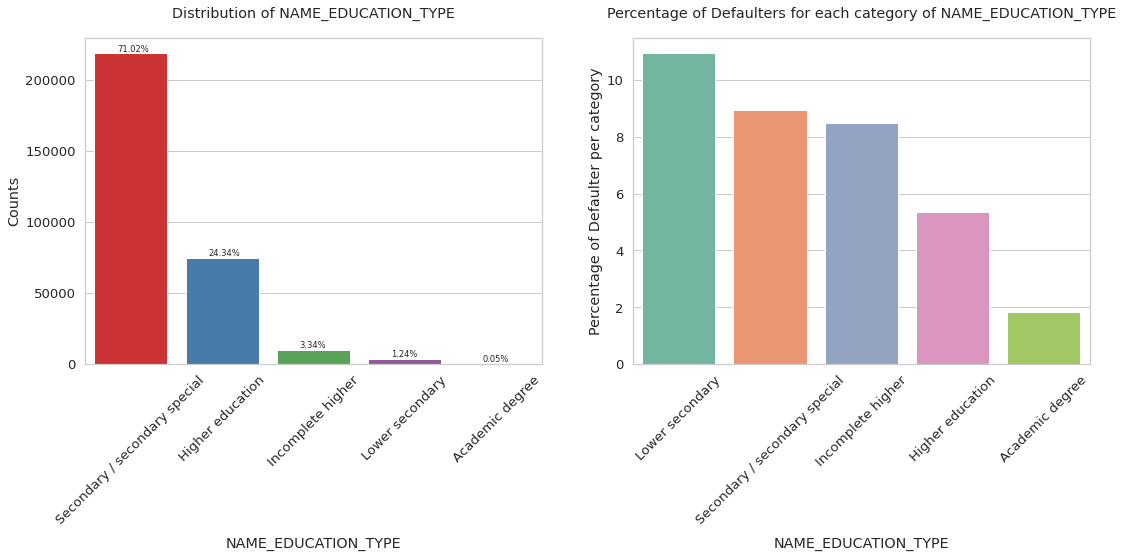

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'NAME_EDUCATION_TYPE'
print_unique_categories(app_train, 'NAME_EDUCATION_TYPE', show_counts = True)

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(app_train, column_name = 'NAME_EDUCATION_TYPE', rotation = 45, horizontal_adjust = 0.25)
print('-'*100)

In [ ]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    
    '''
    Function to plot categorical variables Pie Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()

In [ ]:
#let us first see the unique categories of 'REGION_RATING_CLIENT_W_CITY'
# OUR INTEREST IN ON THE DEFAULT PEOPLE , SO WE WILL ONLY DRAW OUR ATTENTION TO THEM
print_unique_categories(app_train, 'REGION_RATING_CLIENT_W_CITY')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(app_train, column_name = 'REGION_RATING_CLIENT_W_CITY')


The unique categories of 'REGION_RATING_CLIENT_W_CITY' are:
[2 1 3]


----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


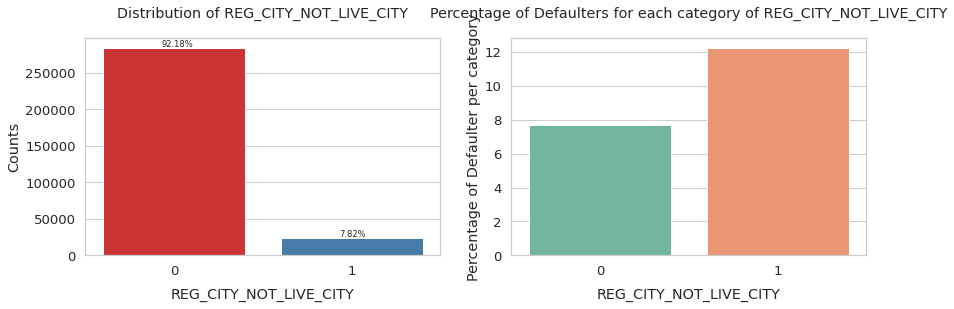

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


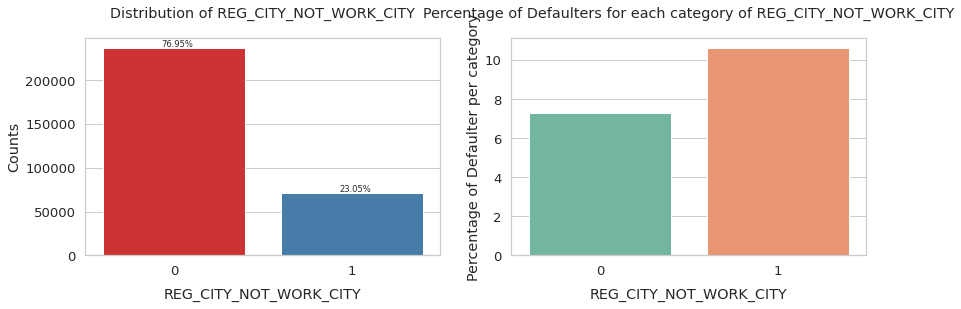

----------------------------------------------------------------------------------------------------
Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


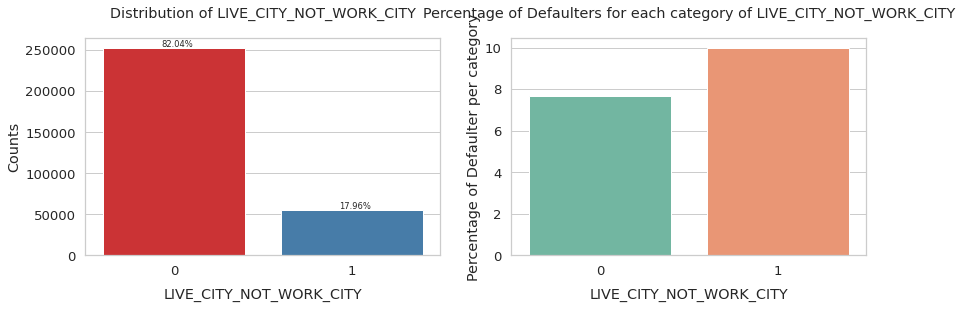

----------------------------------------------------------------------------------------------------


In [ ]:
print('-'*100)
plot_categorical_variables_bar(app_train, column_name = 'REG_CITY_NOT_LIVE_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(app_train, column_name = 'REG_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(app_train, column_name = 'LIVE_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)

## Asking the right questions
for this data analysis

**Who is the highest borrower? Male or Female?**

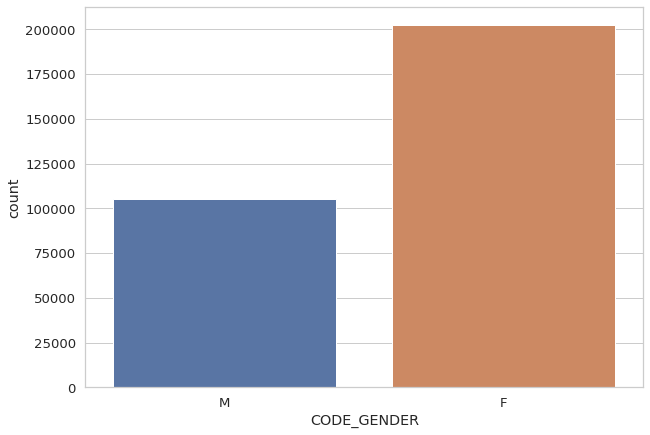

In [ ]:
print("females are the highest borrowers with counts:\n{}".format(app_train.CODE_GENDER.value_counts()))

females are the highest borrowers with counts:
F    202448
M    105059
Name: CODE_GENDER, dtype: int64


**How is the distribution of target labels? - Did most people return on time ?**

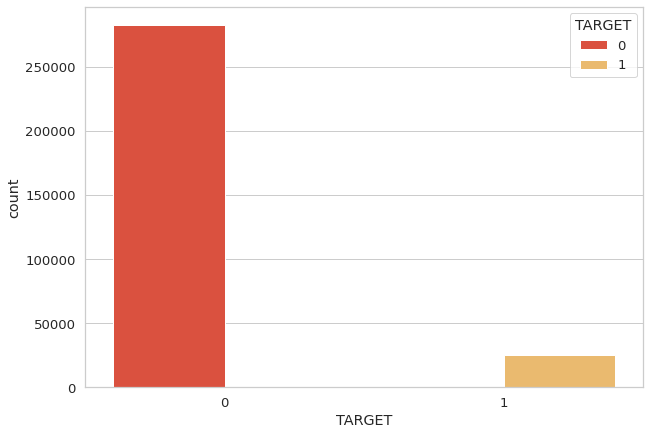

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x ='TARGET',data=app_train, hue='TARGET',palette="YlOrRd_r")

- Based on the description, most people returned the money <br>
{1- people with difficulties, 0 - other cases }.
- Conclusion : Very clearly the target label is imbalanced.

**Whether is it Female who has more difficulties or is it Male?**

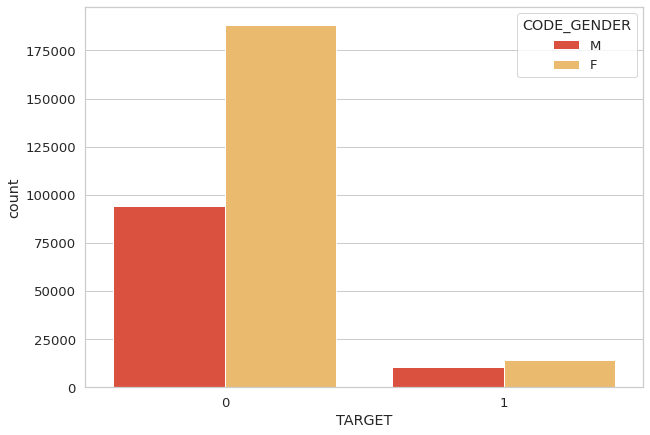

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='TARGET',hue='CODE_GENDER',data=app_train,palette="YlOrRd_r")

Females have relatively more difficulties in repaying the loan back, as seen with Target = 1. This could be because of the general larger population of female applicants as opposed to male applicants.

**What is the minimum number of children do clients have?**

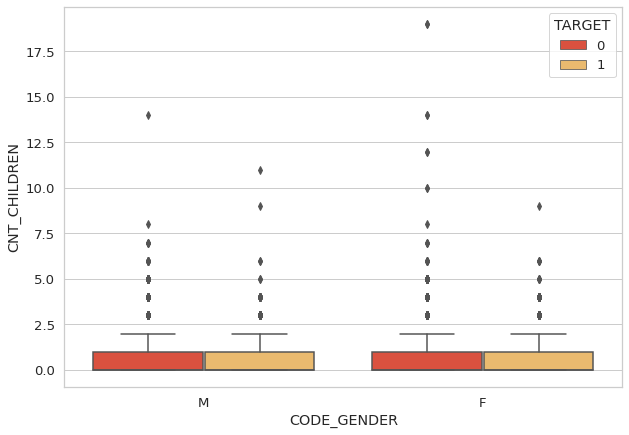

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='CODE_GENDER',y='CNT_CHILDREN',hue='TARGET',data=app_train,palette="YlOrRd_r")

It seems like min children count is 0.

 **Does having a kid influence repayment?**

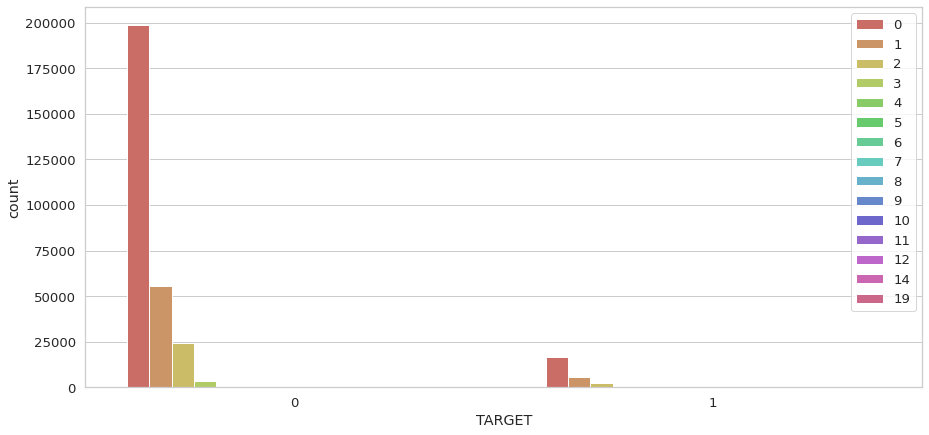

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='TARGET',hue='CNT_CHILDREN',data=app_train,palette="hls")
plt.legend(loc=1)

Most borrowers who have no children had no difficulties repaying - having children impacts the repayment process - it slows down by making it difficult for the client.

 **How many clients have real estate**

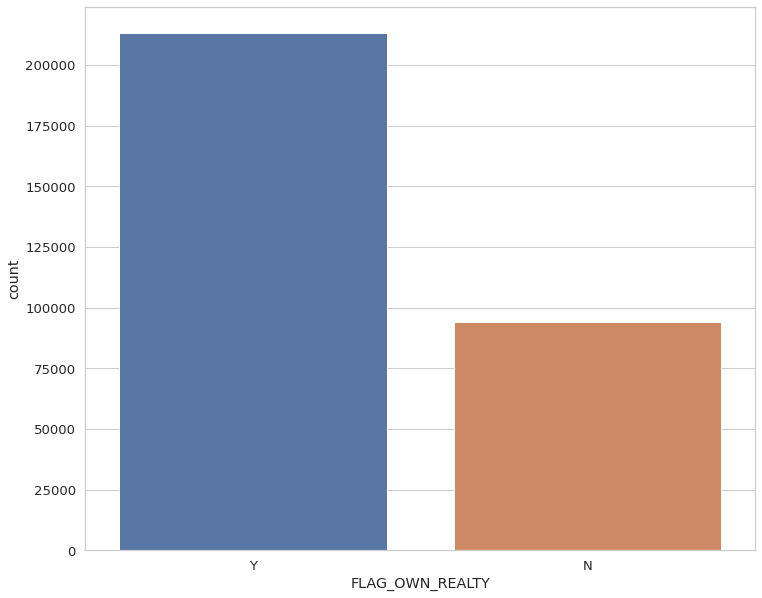

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x='FLAG_OWN_REALTY', data=app_train)

Over 200k applicants have real estate and over 95k applicants don't have.


**How does having real estate influence repaying?**

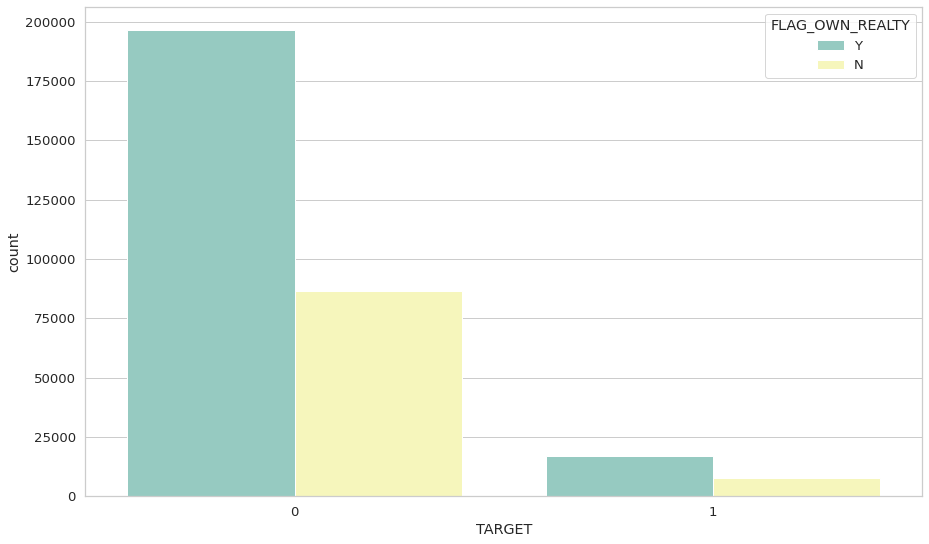

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(x='TARGET',hue='FLAG_OWN_REALTY',data=app_train,palette="Set3")

In [ ]:
reality_with_difficulty = len(app_train[(app_train['FLAG_OWN_REALTY']=='Y') & (app_train['TARGET']==1)])
reality_without_difficulty = len(app_train[(app_train['FLAG_OWN_REALTY']=='Y') & (app_train['TARGET']==0)])
no_reality_with_difficulty = len(app_train[(app_train['FLAG_OWN_REALTY']=='N') & (app_train['TARGET']==1)])
no_reality_without_difficulty = len(app_train[(app_train['FLAG_OWN_REALTY']=='N') & (app_train['TARGET']==0)])

In [ ]:
print("Defaulters with realestate % = ",100*reality_with_difficulty/(reality_with_difficulty+reality_without_difficulty))
print("Defaulters without realestate % = ",100*no_reality_with_difficulty/(no_reality_with_difficulty+no_reality_without_difficulty))

Defaulters with realestate % =  7.961577407740774
Defaulters without realestate % =  8.324929139375152


More defaulters are those who don't have realestate

**How economically stable are clients? Who are the most and least stable?**

Text(0, 0.5, 'Average Annual family income')

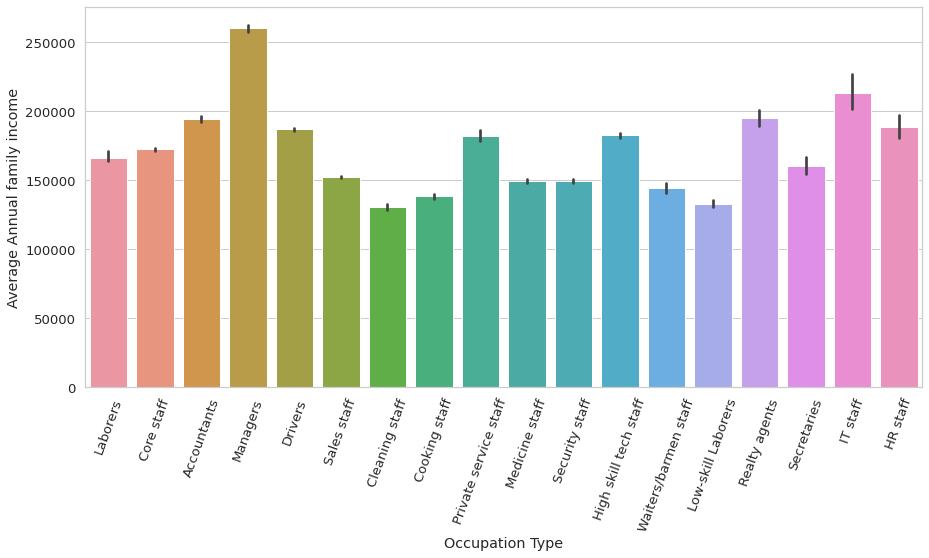

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(x='OCCUPATION_TYPE',y='AMT_INCOME_TOTAL',data=app_train)
plt.xticks(rotation=70)
plt.xlabel("Occupation Type")
plt.ylabel("Average Annual family income")

Managers are the most earning borrowers while cleaning staff are the least earning borrowers - Based on the annual family income.

## EDA of : bureau.csv & bureau_balance.csv

**This table consists of all client's previous credit records with financial institutions other than Home Credit Group which were reported by the the Credit Bureau.**

In [ ]:
bureau = pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/bureau.csv")

In [ ]:
bureau.head(7)
#each application has all the previous record with financial institutions other than home credit

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.8,42103.80,0.00,0.0,Consumer credit,-22,NaN


In [ ]:
print(f'The shape of bureau.csv is: {bureau.shape}')

print(f'Number of unique SK_ID_BUREAU which is each line of bureau in bureau.csv are: {len(bureau.SK_ID_BUREAU.unique())}')
print(f'Number of unique SK_ID_CURR : key for each loan, unique,  in bureau.csv are: {len(bureau.SK_ID_CURR.unique())}')
print(f'Number of overlapping SK_ID_CURR in application_train and bureau are: {len(set(app_train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test and bureau are: {len(set(app_test.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')

print(f'Number of duplicate values in bureau: {bureau.shape[0] - bureau.duplicated().shape[0]}')

display(bureau.head(5))

The shape of bureau.csv is: (1716428, 17)
Number of unique SK_ID_BUREAU which is each line of bureau in bureau.csv are: 1716428
Number of unique SK_ID_CURR : key for each loan, unique,  in bureau.csv are: 305811
Number of overlapping SK_ID_CURR in application_train and bureau are: 263491
Number of overlapping SK_ID_CURR in application_test and bureau are: 42320
Number of duplicate values in bureau: 0


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


***Observations and Conclusions:*** <br>
- The bureau.csv file contains close to 1.7M datapoints, with 17 features. Out of these 17 features, two are SK_ID_CURR and SK_ID_BUREAU. <br>

1.   SK_ID_BUREAU is the loan ID of the client's previous loan from other financial institutions. There may be multiple previous loans corresponding to a single SK_ID_CURR which depends on client's borrowing pattern.
2.   SK_ID_CURR is the loan ID of client's current loan with Home Credit.
The rest of the features contain other stats such as DAYS_CREDIT, AMT_CREDIT_SUM, CREDIT_TYPE, etc.

- There are 305k unique SK_ID_CURR in bureau out of which:
- There are 263k SK_ID_CURR in bureau which are present in application_train out of total of total 307k of application_train's unique SK_ID_CURR. <br>
- This means that some of the applicants in current loan application with Home Credit Group do not have any previous Credit history with Credit Bureau Department.
- Similarly, there are 42.3k SK_ID_CURR in bureau which are present in application_test, out of total 48k of application_test's unique SK_ID_CURR.

***Missing Values***

In [ ]:
#extract the column with the missing values
missing_values_data_b=missing_values(bureau)

 this Dataframe has 17 columns.
There are 7 columns that have missing values.


In [ ]:
#le nom des colonnes ayant des valeurs nulles
missing_values_data_b.head(7)

,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


In [ ]:
print("The columns that do not have missing values in bureau are : ")
not_missing_columns_b=list(set(bureau.columns)-set(missing_values_data_b.index))
not_missing_columns_b

The columns that do not have missing values in bureau are : 


['SK_ID_BUREAU',
 'CREDIT_TYPE',
 'CREDIT_CURRENCY',
 'SK_ID_CURR',
 'DAYS_CREDIT',
 'CREDIT_ACTIVE',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_CREDIT_SUM_OVERDUE',
 'CNT_CREDIT_PROLONG']

***Observations and Conclusions:*** <br>
Out of 17 features, there are 7 features which contain NaN values.
The highest NaN values are observed with the column AMT_ANNUITY which has over 70% missing values.

In [ ]:
bureau['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

## Since we are interested with the defaulters or no defaulters , we are going to merge the DataSets : we have a column in common <br>
- to have a more insights about who may default even tho he took a loan from institutions other than This bank in particular

In [ ]:
print("GET the column TARGET inside the bureau dataset")
bureau_M = app_train.iloc[:,:2].merge(bureau, on = 'SK_ID_CURR', how = 'left')

GET the column TARGET inside the bureau dataset


In [ ]:
bureau_M.head(7)

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.000,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,6158905.0,Closed,currency 1,-476.0,0.0,NaN,-48.0,NaN,0.0,0.000,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,1,6158906.0,Closed,currency 1,-1437.0,0.0,-1072.0,-1185.0,0.000,0.0,135000.000,0.0,0.000,0.0,Consumer credit,-1185.0,0.0
3,100002,1,6158907.0,Closed,currency 1,-1121.0,0.0,-911.0,-911.0,3321.000,0.0,19071.000,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,1,6158908.0,Closed,currency 1,-645.0,0.0,85.0,-36.0,5043.645,0.0,120735.000,0.0,0.000,0.0,Consumer credit,-34.0,0.0
5,100002,1,6158909.0,Active,currency 1,-103.0,0.0,NaN,NaN,40.500,0.0,31988.565,0.0,31988.565,0.0,Credit card,-24.0,0.0
6,100002,1,6158903.0,Active,currency 1,-1042.0,0.0,780.0,NaN,NaN,0.0,450000.000,245781.0,0.000,0.0,Consumer credit,-7.0,0.0


In [ ]:
bureau_M['CREDIT_TYPE'].value_counts()

Consumer credit                                 1069610
Credit card                                      343853
Car loan                                          23757
Mortgage                                          15607
Microloan                                          9005
Loan for business development                      1721
Another type of loan                                854
Unknown type of loan                                472
Loan for working capital replenishment              377
Cash loan (non-earmarked)                            23
Real estate loan                                     23
Loan for the purchase of equipment                   17
Loan for purchase of shares (margin lending)          4
Interbank credit                                      1
Mobile operator loan                                  1
Name: CREDIT_TYPE, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

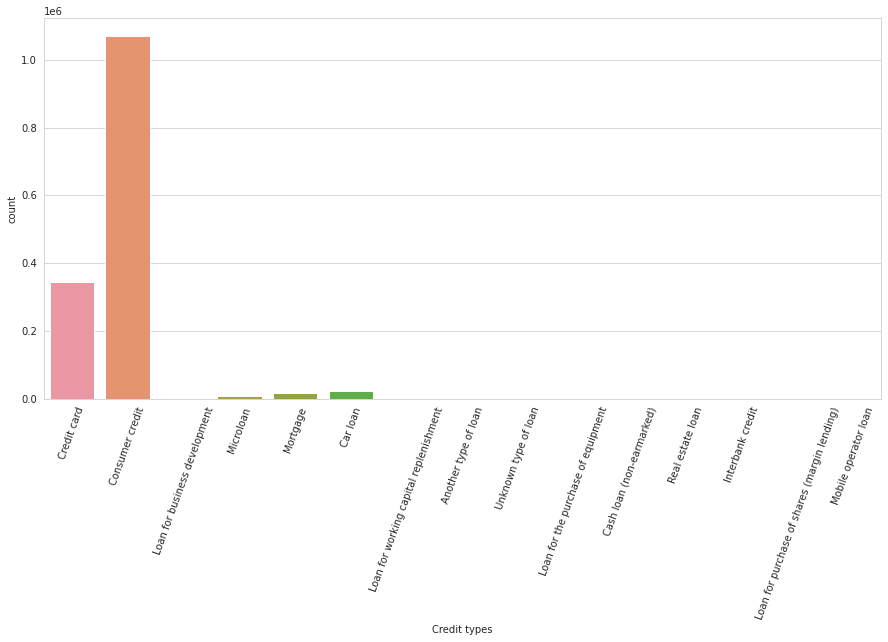

In [ ]:
#Types of credit types
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='CREDIT_TYPE',data=bureau_M)
plt.xlabel("Credit types")
plt.xticks(rotation=70)

In [ ]:
df_corr_BM=correlation_with_target_top_n(bureau_M[bureau_M['TARGET'].notnull()],20)

20 Positive Correlations:
 AMT_CREDIT_SUM           -0.010606
SK_ID_BUREAU             -0.009018
AMT_CREDIT_SUM_LIMIT     -0.005990
SK_ID_CURR               -0.002900
AMT_ANNUITY               0.000117
CNT_CREDIT_PROLONG        0.001523
AMT_CREDIT_MAX_OVERDUE    0.001587
AMT_CREDIT_SUM_DEBT       0.002539
CREDIT_DAY_OVERDUE        0.002652
AMT_CREDIT_SUM_OVERDUE    0.006253
DAYS_CREDIT_ENDDATE       0.026497
DAYS_ENDDATE_FACT         0.039057
DAYS_CREDIT_UPDATE        0.041076
DAYS_CREDIT               0.061556
TARGET                    1.000000
Name: TARGET, dtype: float64

 20  Negative Correlations:
 AMT_CREDIT_SUM           -0.010606
SK_ID_BUREAU             -0.009018
AMT_CREDIT_SUM_LIMIT     -0.005990
SK_ID_CURR               -0.002900
AMT_ANNUITY               0.000117
CNT_CREDIT_PROLONG        0.001523
AMT_CREDIT_MAX_OVERDUE    0.001587
AMT_CREDIT_SUM_DEBT       0.002539
CREDIT_DAY_OVERDUE        0.002652
AMT_CREDIT_SUM_OVERDUE    0.006253
DAYS_CREDIT_ENDDATE       0.026497
DAYS

----------------------------------------------------------------------------------------------------


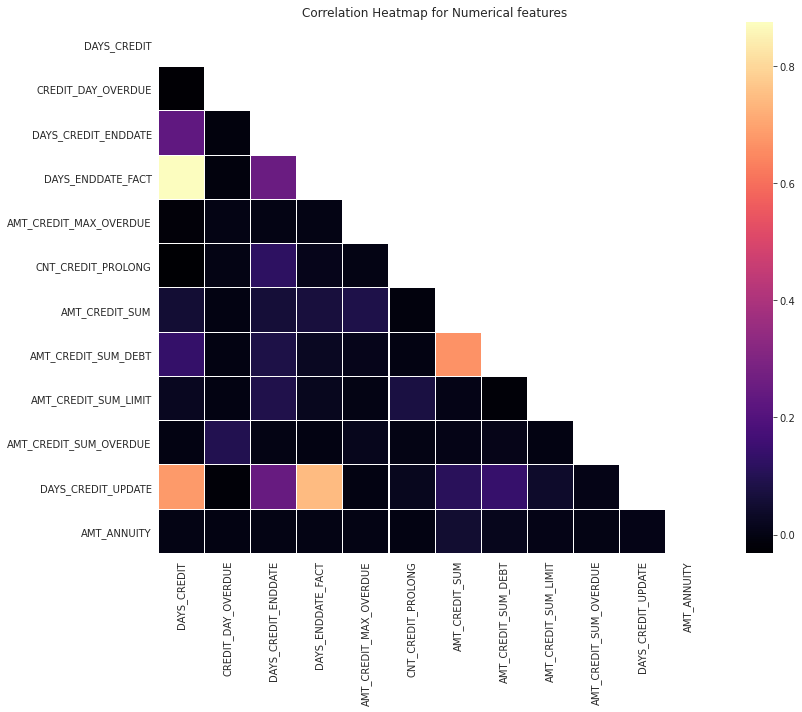

----------------------------------------------------------------------------------------------------


In [ ]:
#Correlation HEATMAP for numerical values
corr_mat_B = correlation_matrix(bureau_M, ['SK_ID_CURR','SK_ID_BUREAU'], cmap = 'magma', figsize = (12,10))
corr_mat_B.plot_correlation_matrix()

## Plotting Categorical Variables
- We will now plot some of the Categorical Variables of the table bureau, and see their impact on the Target Variable.


- This column describes the Status of the previous loan reported from Credit Bureau.

The unique categories of 'CREDIT_ACTIVE' are:
['Closed' 'Active' nan 'Sold' 'Bad debt']
Counts of each category are:
Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64
Total Number of unique categories of CREDIT_ACTIVE = 5


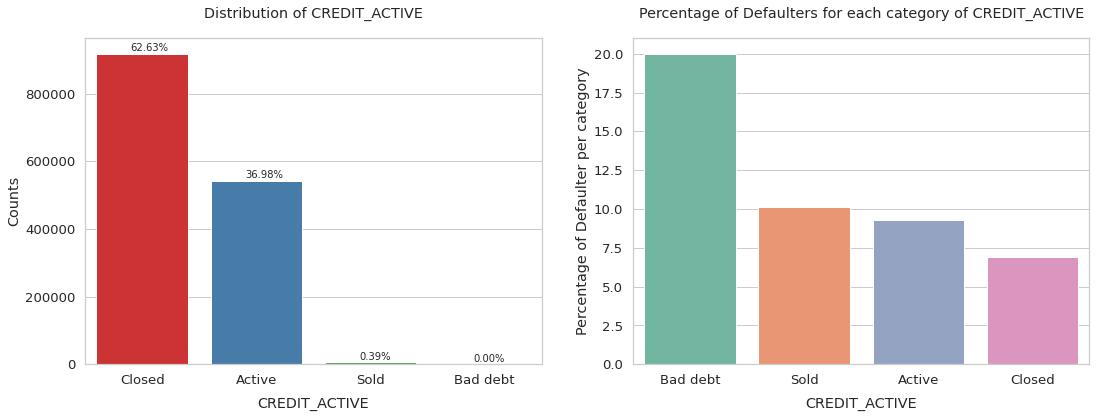

In [ ]:
#let us first see the unique categories of 'CREDIT_ACTIVE'
print_unique_categories(bureau_M, 'CREDIT_ACTIVE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(bureau_M, column_name = 'CREDIT_ACTIVE', horizontal_adjust = 0.3, fontsize_percent = 'x-small')


**Plotting Continuous Variables**<br>
DAYS_CREDIT
This column describes about the number of days before current application when the client applied for Credit Bureau Credit. For ease of interpretability, we will convert these days to years.

In [ ]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

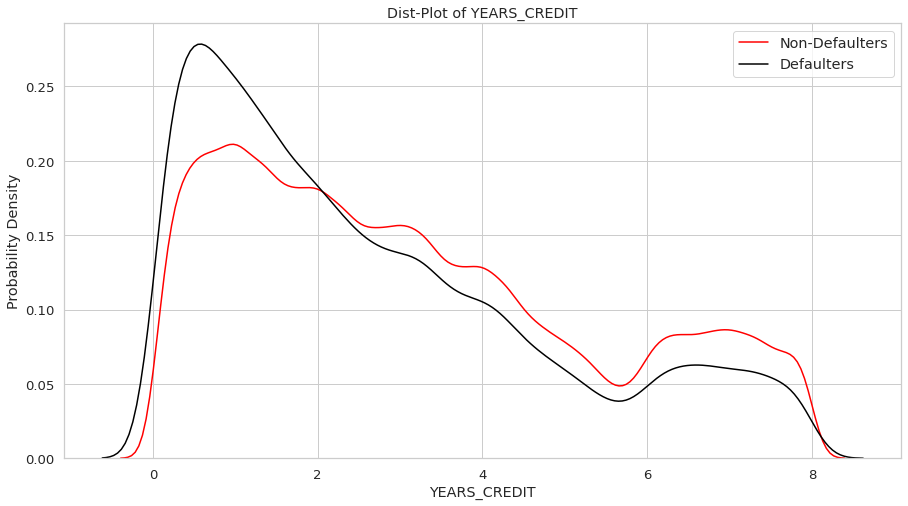

In [ ]:
bureau_M['YEARS_CREDIT'] = bureau_M['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_M, 'YEARS_CREDIT', plots = ['distplot'], figsize = (15,8))
_ = bureau_M.pop('YEARS_CREDIT')

**DAYS_CREDIT_ENDDATE** <br>

This column tells about the remaining duration of Credit Bureau credit at the time of application for loan in Home Credit.

In [ ]:
def print_percentiles(data, column_name, percentiles = None):
    
    '''
    Function to print percentile values for given column
    
    Inputs:
        data: DataFrame
            The DataFrame from which to print percentiles
        column_name: str
            Column's name whose percentiles are to be printed
        percentiles: list, default = None
            The list of percentiles to print, if not given, default are printed
    '''
    
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_ENDDATE is -42060.0
The 2th percentile value of DAYS_CREDIT_ENDDATE is -2487.0
The 4th percentile value of DAYS_CREDIT_ENDDATE is -2334.0
The 6th percentile value of DAYS_CREDIT_ENDDATE is -2202.0
The 8th percentile value of DAYS_CREDIT_ENDDATE is -2073.9199999999983
The 10th percentile value of DAYS_CREDIT_ENDDATE is -1939.0
The 25th percentile value of DAYS_CREDIT_ENDDATE is -1144.0
The 50th percentile value of DAYS_CREDIT_ENDDATE is -334.0
The 75th percentile value of DAYS_CREDIT_ENDDATE is 473.0
The 100th percentile value of DAYS_CREDIT_ENDDATE is 31199.0
----------------------------------------------------------------------------------------------------


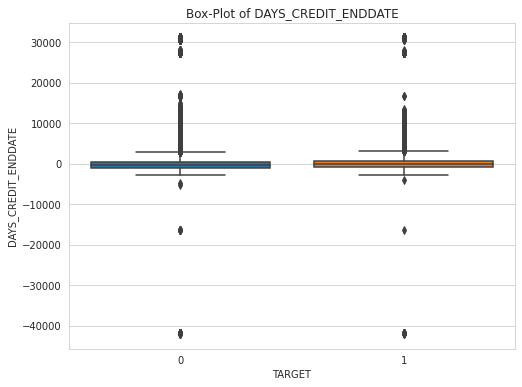

----------------------------------------------------------------------------------------------------


In [ ]:

print_percentiles(bureau_M, 'DAYS_CREDIT_ENDDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_M, 'DAYS_CREDIT_ENDDATE', plots = ['box'], figsize = (8,6))
print('-'*100)


**bureau_balance.csv** <br>
*Description* <br>
This table consists of Monthly balance of each credit for each of the previous credit that the client had with financial institutions other than Home Credit.

In [ ]:
bureau_balance = pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/bureau_balance.csv")

In [ ]:
print(f'The shape of bureau_balance is: {bureau_balance.shape}')

print(f'Number of duplicate values in bureau_balance: {bureau_balance.shape[0] - bureau_balance.duplicated().shape[0]}')

display(bureau_balance.head(7))

The shape of bureau_balance is: (27299925, 3)
Number of duplicate values in bureau_balance: 0


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C


In [ ]:
print(f'Number of unique SK_ID_BUREAU in bureau_balance.csv are: {len(bureau_balance.SK_ID_BUREAU.unique())}')

print(f'Number of unique values for STATUS are: {len(bureau_balance.STATUS.unique())}')
print(f"Unique values of STATUS are:\n{bureau_balance.STATUS.unique()}")

print(f"Max number of months for Months Balance: {np.abs(bureau_balance.MONTHS_BALANCE.min())}")


Number of unique SK_ID_BUREAU in bureau_balance.csv are: 817395
Number of unique values for STATUS are: 8
Unique values of STATUS are:
['C' '0' 'X' '1' '2' '3' '5' '4']
Max number of months for Months Balance: 96


**Observations and Conclusions** <br>
The bureau_balance.csv table contains approximately 27.29M rows, and 3 columns.
This table contains the monthly status for each of the previous loan for a particular applicant reported by the Credit Bureau Department.
There are 8 unique values for the STATUS which are encoded. Each of them have a special meaning.
C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off.
The most earliest month's balance that we have is the 96 months back status, i.e. the Status has been provided upto 8 years of history for loans for which those exist.

In [ ]:
#extract the column with the missing values
missing_values_data_bl=missing_values(bureau_balance)

 this Dataframe has 3 columns.
There are 0 columns that have missing values.


In [ ]:
#le nom des colonnes ayant des valeurs nulles
missing_values_data_bl.head(7)

,Missing Values,% of Total Values


## previous_application.csv<br>
**Description** <br>
This table contains the static data of the previous loan which the client had with Home Credit.

In [ ]:
previous_application = pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/previous_application.csv")

In [ ]:
print(f'The shape of previous_application.csv is: {previous_application.shape}')

print(f'Number of unique SK_ID_PREV in previous_application.csv are: {len(previous_application.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in previous_application.csv are: {len(previous_application.SK_ID_CURR.unique())}')

print(f'Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: {len(set(app_train.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: {len(set(app_test.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')

print(f'Number of duplicate values in previous_application: {previous_application.shape[0] - previous_application.duplicated().shape[0]}')

display(previous_application.head(7))

The shape of previous_application.csv is: (1670214, 37)
Number of unique SK_ID_PREV in previous_application.csv are: 1670214
Number of unique SK_ID_CURR in previous_application.csv are: 338857
Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: 291057
Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: 47800
Number of duplicate values in previous_application: 0


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Y,1,NaN,NaN,NaN,Everyday expenses,Approved,-684,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Canceled,-14,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


**Observations and Conclusions:**<br>
The table previous_application.csv consists of 1.67M rows in total. Each row corresponds to each of the previous loan that the client had with previously with Home Credit Group. It is possible for a single client of current application to have multiple previous loans with Home Credit Group.
There are 37 columns in previous_application.csv, which contain the details about the previous loan.
There are 338k unique SK_ID_CURR in previous_application, of which 291k correspond to the application_train SK_ID_CURRs and 47.8k correspond to application_test SK_ID_CURRs.

In [ ]:
#extract the column with the missing values
missing_values_data_PR=missing_values(previous_application)

 this Dataframe has 37 columns.
There are 16 columns that have missing values.


In [ ]:
#le nom des colonnes ayant des valeurs nulles
missing_values_data_PR.head(7)

,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3


Merging the TARGETS from application_train to previous_application table.
Since we are more interested into the defaulters

In [ ]:
print("Merging TARGET with previous_application Table")
prev_M = app_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')


Merging TARGET with previous_application Table


In [ ]:
df_corr_PM=correlation_with_target_top_n(prev_M[prev_M['TARGET'].notnull()],20)

20 Positive Correlations:
 RATE_DOWN_PAYMENT           -0.026111
AMT_DOWN_PAYMENT            -0.016918
AMT_ANNUITY                 -0.014922
DAYS_FIRST_DUE              -0.006651
AMT_APPLICATION             -0.005583
NFLAG_LAST_APPL_IN_DAY      -0.002887
SELLERPLACE_AREA            -0.002539
AMT_CREDIT                  -0.002350
RATE_INTEREST_PRIMARY       -0.001470
SK_ID_CURR                  -0.001216
AMT_GOODS_PRICE              0.000254
NFLAG_INSURED_ON_APPROVAL    0.000653
SK_ID_PREV                   0.002009
DAYS_TERMINATION             0.016981
DAYS_LAST_DUE                0.017522
DAYS_LAST_DUE_1ST_VERSION    0.018021
RATE_INTEREST_PRIVILEGED     0.028640
CNT_PAYMENT                  0.030480
DAYS_DECISION                0.039901
TARGET                       1.000000
Name: TARGET, dtype: float64

 20  Negative Correlations:
 DAYS_FIRST_DRAWING          -0.031154
HOUR_APPR_PROCESS_START     -0.027809
RATE_DOWN_PAYMENT           -0.026111
AMT_DOWN_PAYMENT            -0.016918
AM

----------------------------------------------------------------------------------------------------


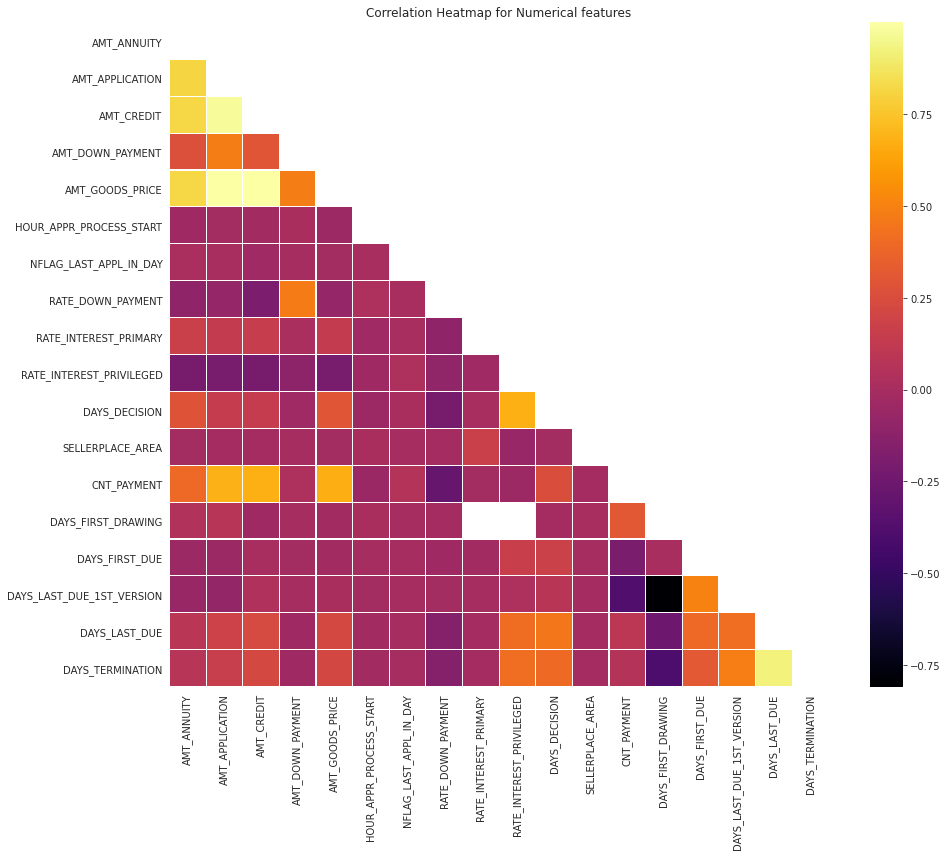

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat_PVM = correlation_matrix(prev_M, ['SK_ID_CURR','SK_ID_PREV','NFLAG_INSURED_ON_APPROVAL'], cmap = 'inferno', figsize = (14,12))
corr_mat_PVM.plot_correlation_matrix()

The unique categories of 'NAME_CONTRACT_TYPE' are:
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
Counts of each category are:
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: NAME_CONTRACT_TYPE, dtype: int64
Total Number of unique categories of NAME_CONTRACT_TYPE = 5


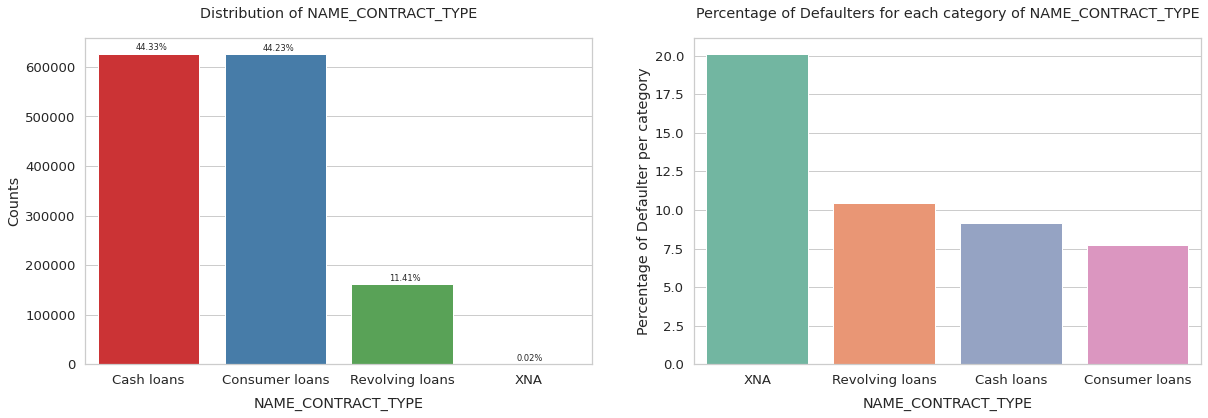

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_M, 'NAME_CONTRACT_TYPE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_M, 'NAME_CONTRACT_TYPE', horizontal_adjust = 0.3, figsize = (20, 6))
print('-'*100)

The unique categories of 'NAME_CONTRACT_STATUS' are:
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
Total Number of unique categories of NAME_CONTRACT_STATUS = 5


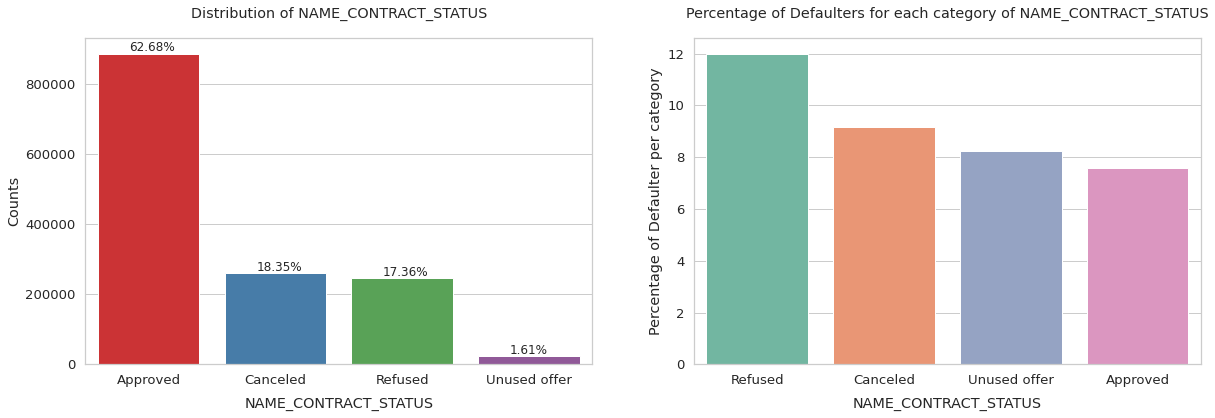

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(prev_M, 'NAME_CONTRACT_STATUS')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_M, 'NAME_CONTRACT_STATUS', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

REASONS FOR REJECTION:

This column describes the reason of the rejection of previously applied loan in Home Credit Group.

The unique categories of 'CODE_REJECT_REASON' are:
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
Counts of each category are:
XAP       1145533
HC         145984
LIMIT       47773
SCO         32636
CLIENT      22771
SCOFR       10875
XNA          4378
VERIF        3079
SYSTEM        672
Name: CODE_REJECT_REASON, dtype: int64
Total Number of unique categories of CODE_REJECT_REASON = 10


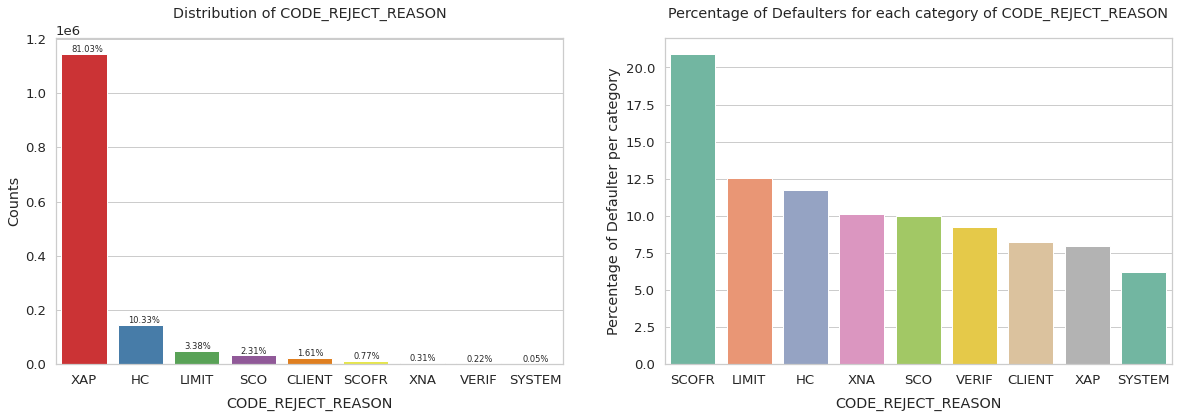

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'CODE_REJECT_REASON'
print_unique_categories(prev_M, 'CODE_REJECT_REASON', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_M, 'CODE_REJECT_REASON', horizontal_adjust = 0.18, figsize = (20, 6))
print('-'*100)


**'PRODUCT_COMBINATION' ** : This column gives details about the product combination of the previous applications.

The unique categories of 'PRODUCT_COMBINATION' are:
['POS other with interest' 'Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'POS mobile without interest' 'Card Street'
 'Card X-Sell' 'Cash X-Sell: high' 'Cash' 'Cash Street: high'
 'Cash X-Sell: middle' 'POS mobile with interest'
 'POS household without interest' 'POS industry without interest'
 'Cash Street: low' nan 'Cash Street: middle'
 'POS others without interest']
Total Number of unique categories of PRODUCT_COMBINATION = 18


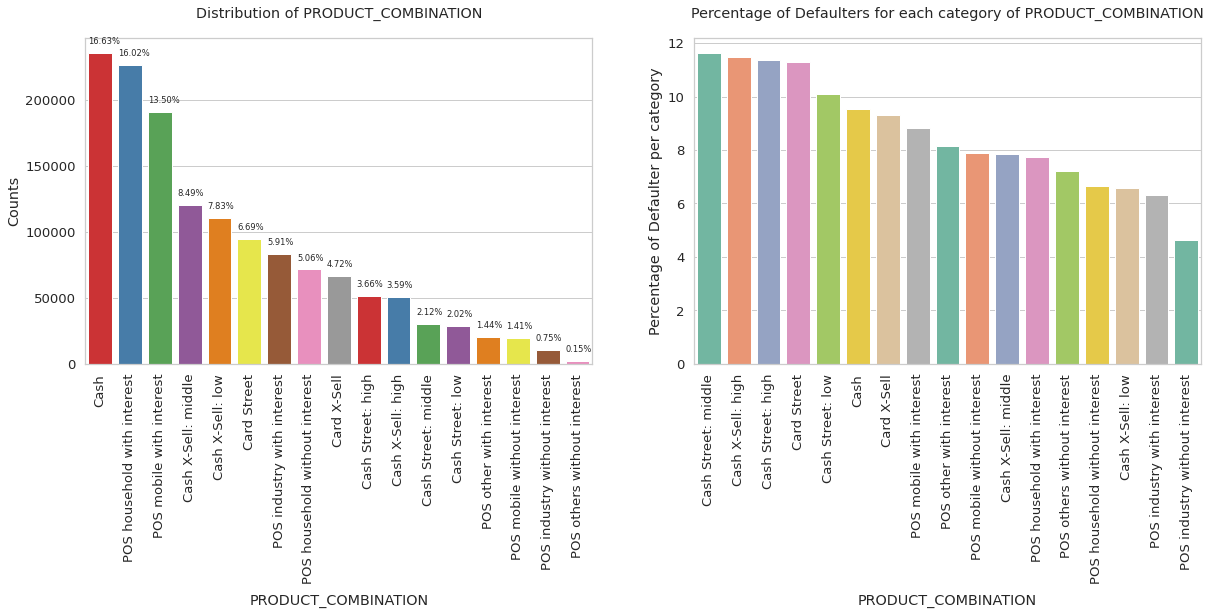

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'PRODUCT_COMBINATION'
print_unique_categories(prev_M, 'PRODUCT_COMBINATION')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_M, 'PRODUCT_COMBINATION', rotation = 90, figsize = (20, 6))
print('-'*100)

DAYS_DECISION

This column tells about the number of days relative to the current application when the decision was made about previous application.

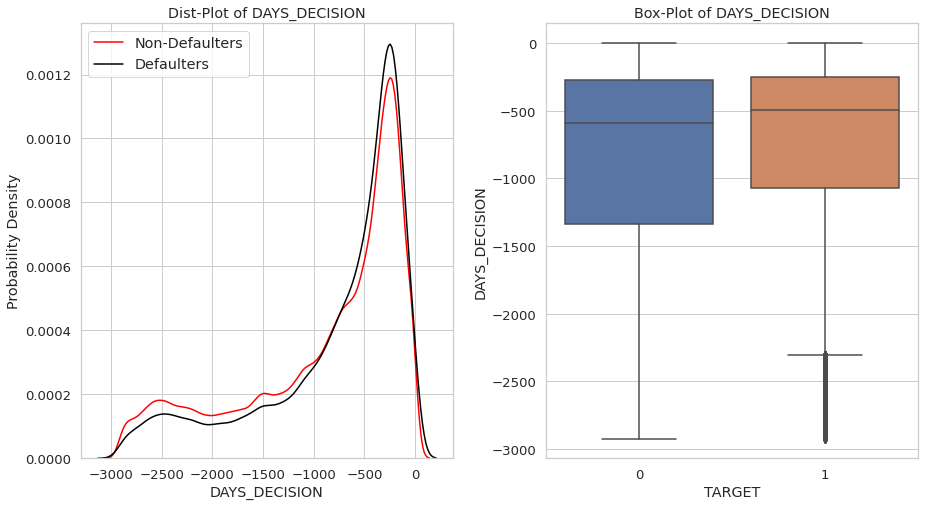

In [ ]:
plot_continuous_variables(prev_M, 'DAYS_DECISION', plots = ['distplot', 'box'], figsize = (15,8))


**Observations and Conclusions**
- From the above plot, we notice that for Defaulters, the number of days back when the decision was made is a bit lesser than that for Non-Defaulters. This implies that the Defaulters usually had the decision on their previous applications made more recently as compared to Non-Defaulters.

In [ ]:
installments_payments = pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/installments_payments.csv")

**Description**
This table lists out the repayment history of each of the loan that the applicant had with Home Credit Group. The table contains features like the amount of instalment, how much did the client pay for each instalments, etc.

In [ ]:
print(f'The shape of installments_payments.csv is: {installments_payments.shape}')

print(f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(installments_payments.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(installments_payments.SK_ID_CURR.unique())}')

print(f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(app_train.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: {len(set(app_test.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')

print(f'Number of duplicate values in installments_payments: {installments_payments.shape[0] - installments_payments.duplicated().shape[0]}')

display(installments_payments.head(7))

The shape of installments_payments.csv is: (13605401, 8)
Number of unique SK_ID_PREV in installments_payments.csv are: 997752
Number of unique SK_ID_CURR in installments_payments.csv are: 339587
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 291643
Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: 47944
Number of duplicate values in installments_payments: 0


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295


In [ ]:
#extract the column with the missing values
missing_values_data_IP=missing_values(installments_payments)

 this Dataframe has 8 columns.
There are 2 columns that have missing values.


In [ ]:
#le nom des colonnes ayant des valeurs nulles
missing_values_data_IP.head(7)

,Missing Values,% of Total Values
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


In [ ]:
print("Merging TARGET with installments_payments Table")
install_M = app_train.iloc[:,:2].merge(installments_payments, on = 'SK_ID_CURR', how = 'left')

Merging TARGET with installments_payments Table


In [ ]:
df_corr_IP=correlation_with_target_top_n(install_M[install_M['TARGET'].notnull()],20)

20 Positive Correlations:
 NUM_INSTALMENT_NUMBER    -0.016190
NUM_INSTALMENT_VERSION   -0.009896
AMT_PAYMENT              -0.003623
SK_ID_CURR               -0.002533
AMT_INSTALMENT           -0.001498
SK_ID_PREV               -0.000212
DAYS_INSTALMENT           0.034974
DAYS_ENTRY_PAYMENT        0.035122
TARGET                    1.000000
Name: TARGET, dtype: float64

 20  Negative Correlations:
 NUM_INSTALMENT_NUMBER    -0.016190
NUM_INSTALMENT_VERSION   -0.009896
AMT_PAYMENT              -0.003623
SK_ID_CURR               -0.002533
AMT_INSTALMENT           -0.001498
SK_ID_PREV               -0.000212
DAYS_INSTALMENT           0.034974
DAYS_ENTRY_PAYMENT        0.035122
TARGET                    1.000000
Name: TARGET, dtype: float64


----------------------------------------------------------------------------------------------------


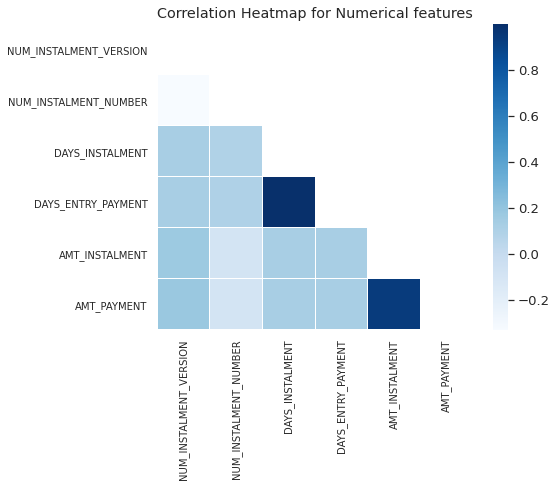

----------------------------------------------------------------------------------------------------


In [ ]:
#Correlation Matrix of Features
corr_mat_IP = correlation_matrix(install_M, ['SK_ID_CURR','SK_ID_PREV'], figsize = (8,7))
corr_mat_IP.plot_correlation_matrix()

**Plotting Continuous Variables**
Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

In [ ]:
#This column lists the days when the installment of previous credit was to be paid.
install_M = install_M.groupby('SK_ID_PREV').mean()

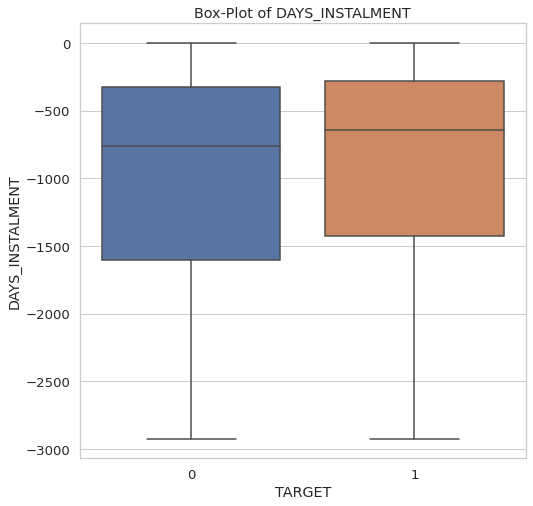

In [ ]:
plot_continuous_variables(install_M, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8,8))

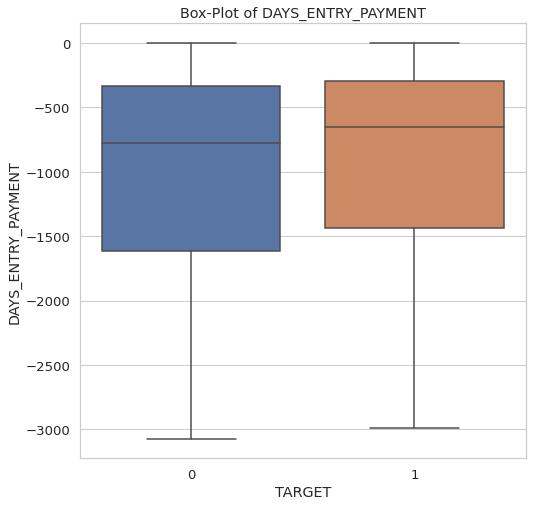

In [ ]:
#This column lists the days when the installment of previous credit was actually paid.
plot_continuous_variables(install_M, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize = (8,8))
#del installments_merged

**Observations and Conclusions**
From the above two plots, we can see a similar pattern, where the Defaulters tend to have lesser number of days since their last payment, while Non-Defaulters have more number of days since their last payments. All quantiles of Defaulters have more recent days than those of Non-Defaulters. Thus, Non-Defaulters usually have more gap in their payments from the day of application as compared to Defaulters.

## POS_CASH_balance.csv
**Description** <br>
This table contains the Monthly Balance Snapshots of previous Point of Sales and Cash Loans that the applicant had with Home Credit Group. The table contains columns like the status of contract, the number of installments left, etc.

In [ ]:
POS_CASH_balance = pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/POS_CASH_balance.csv")

In [ ]:
print(f'The shape of POS_CASH_balance.csv is: {POS_CASH_balance.shape}')

print(f'Number of unique SK_ID_PREV in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_CURR.unique())}')

print(f'Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: {len(set(app_train.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: {len(set(app_test.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')

print(f'Number of duplicate values in POS_CASH_balance: {POS_CASH_balance.shape[0] - POS_CASH_balance.duplicated().shape[0]}')

display(POS_CASH_balance.head(7))

The shape of POS_CASH_balance.csv is: (10001358, 8)
Number of unique SK_ID_PREV in POS_CASH_balance.csv are: 936325
Number of unique SK_ID_CURR in POS_CASH_balance.csv are: 337252
Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: 289444
Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: 47808
Number of duplicate values in POS_CASH_balance: 0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0


**Observations and Conclusions** <br>
- This table contains around 10M datapoints, where each row corresponds to the monthly snapshot of the status of the previous POS and Cash Loan that the client had with Home Credit Group. It consists of 8 columns, two of which are SK_ID_CURR and SK_ID_PREV.
- There are 936k unique previous loan IDs in the table, which correspond to 337k unique current applicants (SK_ID_CURR).
Out of these 337k SK_ID_CURR, 289k belong to training set and 47.8k belong to test set

In [ ]:
#extract the column with the missing values
missing_values_data_POS=missing_values(POS_CASH_balance)

 this Dataframe has 8 columns.
There are 2 columns that have missing values.


In [ ]:
#le nom des colonnes ayant des valeurs nulles
missing_values_data_POS.head(7)

,Missing Values,% of Total Values
CNT_INSTALMENT_FUTURE,26087,0.3
CNT_INSTALMENT,26071,0.3


**Observations and Conclusions**
- There are only 2 columns which contain NaN values of the 8 columns from POS_CASH_balance. These columns are the Counts of Installments remaining and the term of the loan.
- These columns also contain very minimal proportion of NaN values, i.e only 0.26%%, so it is also not of much concern.

**Merging the TARGETS from application_train to POS_CASH_balance table.**

In [ ]:
print("Merging TARGET with POS_CASH_balance Table")
pos_cash_M = app_train.iloc[:,:2].merge(POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')


Merging TARGET with POS_CASH_balance Table


----------------------------------------------------------------------------------------------------


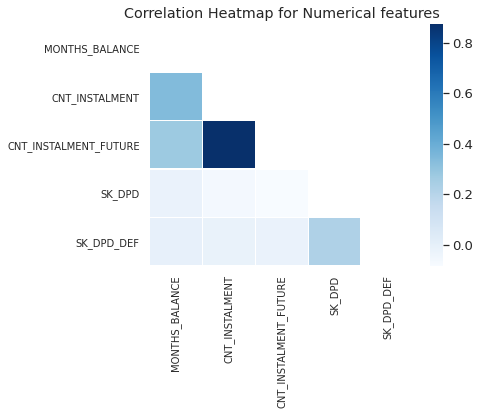

----------------------------------------------------------------------------------------------------


In [ ]:
#Correlation Matrix of Features
corr_mat_POSM = correlation_matrix(pos_cash_M, ['SK_ID_CURR','SK_ID_PREV'], figsize = (7,6))
corr_mat_POSM.plot_correlation_matrix()

In [ ]:
df_corr_POSM=correlation_with_target_top_n(pos_cash_M[pos_cash_M['TARGET'].notnull()],20)

20 Positive Correlations:
 SK_ID_CURR              -0.002244
SK_ID_PREV              -0.000056
SK_DPD_DEF               0.008594
SK_DPD                   0.009866
CNT_INSTALMENT           0.018506
MONTHS_BALANCE           0.020147
CNT_INSTALMENT_FUTURE    0.021972
TARGET                   1.000000
Name: TARGET, dtype: float64

 20  Negative Correlations:
 SK_ID_CURR              -0.002244
SK_ID_PREV              -0.000056
SK_DPD_DEF               0.008594
SK_DPD                   0.009866
CNT_INSTALMENT           0.018506
MONTHS_BALANCE           0.020147
CNT_INSTALMENT_FUTURE    0.021972
TARGET                   1.000000
Name: TARGET, dtype: float64


**Plotting Continuous Variables** <br>
Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

In [ ]:
pos_cash_M = pos_cash_M.groupby('SK_ID_PREV').mean()

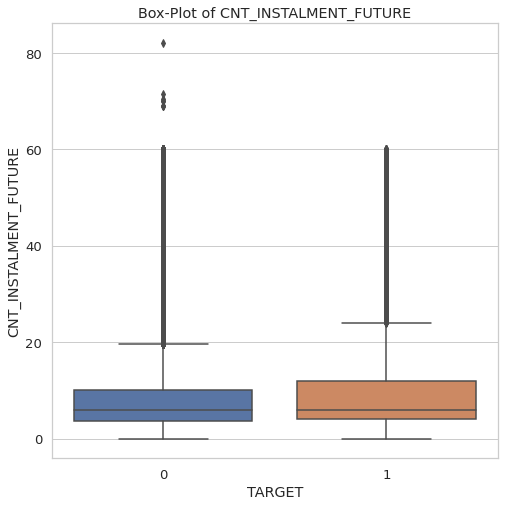

In [ ]:
#This column describes the number of installments left to pay on the previous credit.

plot_continuous_variables(pos_cash_M, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))
#del pos_cash_merged

**Observations and Conclusions**
- Looking at the above box-plot for CNT_INSTALMENT_FUTURE, we see that the percentile values>50% for Defaulters are usually higher than those of Non-Defaulters. Even the upper limit whisker for Defaulters is higher than that of Non-Defaulters. This suggests that the Defaulters tend to have more number of Installments remaining on their previous credits as compared to Non-Defaulters.

## credit_card_balance.csv
***Description*** <br>
This table consists of the monthly data related to any or multiple Credit Cards that the applicant had with the Home Credit Group. The table contains fields like balance, the credit limit, amount of drawings, etc. for each month of the credit card.

In [ ]:
creditC_balance = pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/credit_card_balance.csv")

In [ ]:
print(f'The shape of credit_card_balance.csv is: {creditC_balance.shape}')

print(f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(creditC_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(creditC_balance.SK_ID_CURR.unique())}')

print(f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(app_train.SK_ID_CURR.unique()).intersection(set(creditC_balance.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: {len(set(app_test.SK_ID_CURR.unique()).intersection(set(creditC_balance.SK_ID_CURR.unique())))}')


print(f'Number of duplicate values in credit_card_balance: {creditC_balance.shape[0] - creditC_balance.duplicated().shape[0]}')

display(creditC_balance.head(7))

The shape of credit_card_balance.csv is: (3840312, 23)
Number of unique SK_ID_PREV in credit_card_balance.csv are: 104307
Number of unique SK_ID_CURR in credit_card_balance.csv are: 103558
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 86905
Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: 16653
Number of duplicate values in credit_card_balance: 0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000,0.0,0.0,0.0,0.0,4449.105,3825.0,3825.0,80519.040,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000,67500.0,67500.0,0.0,0.0,14684.175,15750.0,15750.0,345433.860,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0


**Observations and Conclusions** <br>
- There are around 3.84M rows in the table credit_card_balance.csv, each of which corresponds to the monthly status of the Credit Card which the applicant had with Home Credit Group. This table contains 23 features which contain the statistics about each month's Credit Card status, such as Balance amount, Amount of Drawings, Number of drawings, status, etc.
- There are 104.3k unique Credit Cards whose details are in this table.
Out of these 104.3k there are 103.5k unique SK_ID_CURR. What this means is that most of the applicants had just 1 credit card with them, and only few of them had more than 1. These SK_ID_CURR are the ID of the applicants who have currently applied for loan.
- Out of the 103k unique SK_ID_CURR, 86.9k of these applicants belong to the training set, and 16.6k belong to test application set.
Out of 307k applicants in application_train table, only 86.9k of those had a credit card previously with Home Credit Group.

In [ ]:
#extract the column with the missing values
missing_values_data_CC=missing_values(creditC_balance)

 this Dataframe has 23 columns.
There are 9 columns that have missing values.


In [ ]:
#le nom des colonnes ayant des valeurs nulles
missing_values_data_CC.head(7)

,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5


**Observatiosn and Conclusions**
- Out of the 23 features, 9 of these features contain some NaN values.
- If we look at the percentages of NaN values, they are considerably lower than the rest of the tables we have seen so far.
- 7 of these features have close to 20% NaN values. These features are mostly related to the Amounts of Drawing and Counts of Drawings. Other two of the features are related to the installments statistics.

In [ ]:
#Merging the TARGETS from application_train to credit_card_balance table.

print("Merging TARGET with credit_card_balance Table")
cc_balance_M = app_train.iloc[:,:2].merge(creditC_balance, on = 'SK_ID_CURR', how = 'left')


Merging TARGET with credit_card_balance Table


----------------------------------------------------------------------------------------------------


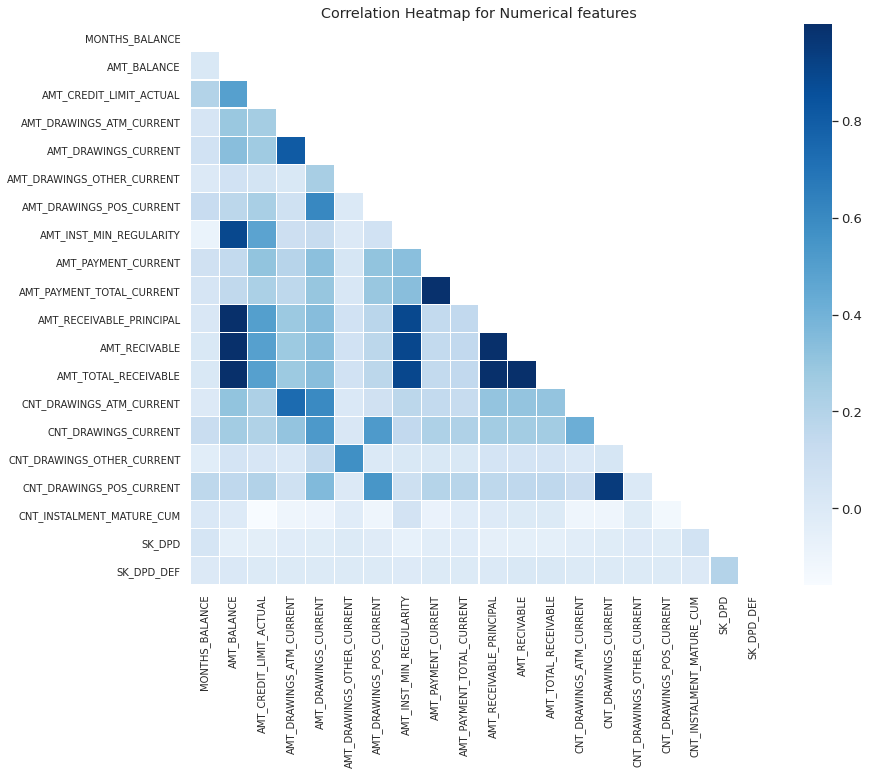

----------------------------------------------------------------------------------------------------


In [ ]:
#Correlation Matrix
corr_mat_CC = correlation_matrix(cc_balance_M, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat_CC.plot_correlation_matrix()

- From the heatmap of correlation matrix, we see a few couples of highly correlated features. These are:
- AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE and AMT_BALANCE
- We also observe high correlation between these 3 AMT_RECEIVABLE columns
AMT_PAYMENT_TOTAL_CURRENT and AMT_PAYMENT_CURRENT

In [ ]:
df_corr_CC=correlation_with_target_top_n(cc_balance_M[cc_balance_M['TARGET'].notnull()],20)

20 Positive Correlations:
 SK_ID_PREV                    0.002571
CNT_DRAWINGS_OTHER_CURRENT    0.003044
AMT_DRAWINGS_OTHER_CURRENT    0.003843
AMT_DRAWINGS_POS_CURRENT      0.005084
SK_DPD_DEF                    0.010538
AMT_PAYMENT_TOTAL_CURRENT     0.012302
AMT_PAYMENT_CURRENT           0.012929
AMT_CREDIT_LIMIT_ACTUAL       0.013823
AMT_DRAWINGS_CURRENT          0.022378
AMT_DRAWINGS_ATM_CURRENT      0.024700
CNT_DRAWINGS_POS_CURRENT      0.029536
MONTHS_BALANCE                0.035695
CNT_DRAWINGS_CURRENT          0.037793
CNT_DRAWINGS_ATM_CURRENT      0.038437
AMT_INST_MIN_REGULARITY       0.039798
AMT_RECEIVABLE_PRINCIPAL      0.049692
AMT_RECIVABLE                 0.049803
AMT_TOTAL_RECEIVABLE          0.049839
AMT_BALANCE                   0.050098
TARGET                        1.000000
Name: TARGET, dtype: float64

 20  Negative Correlations:
 CNT_INSTALMENT_MATURE_CUM    -0.023684
SK_ID_CURR                   -0.004412
SK_DPD                        0.001684
SK_ID_PREV       

**Plotting Continuous Variables**
- Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

In [ ]:
cc_balance_M = cc_balance_M.groupby('SK_ID_PREV').mean()


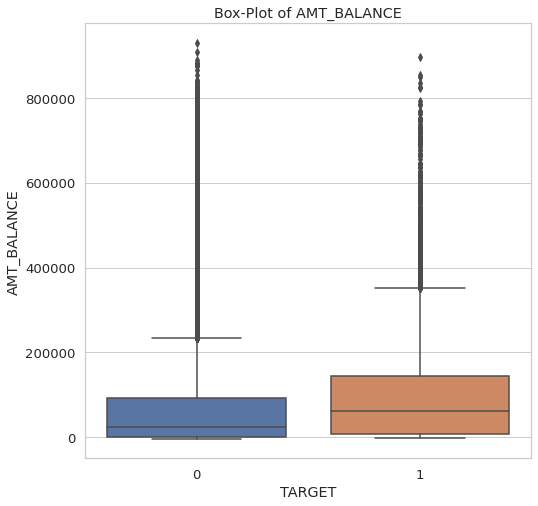

In [ ]:
#This column provided the average amount of balance that a person usually had on his credit card loan account for previous loan.
plot_continuous_variables(cc_balance_M, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

**Observations and Conclusions**
- From the above plot, it can be seen that the Defaulters have a higher value of AMT_BALANCE as compared to Non-Defaulters. They show a higher values of all the quantiles and even the whiskers. This could imply that the Credit amount for Defaulters could also be relatively higher as compared to Non-Defaulters.

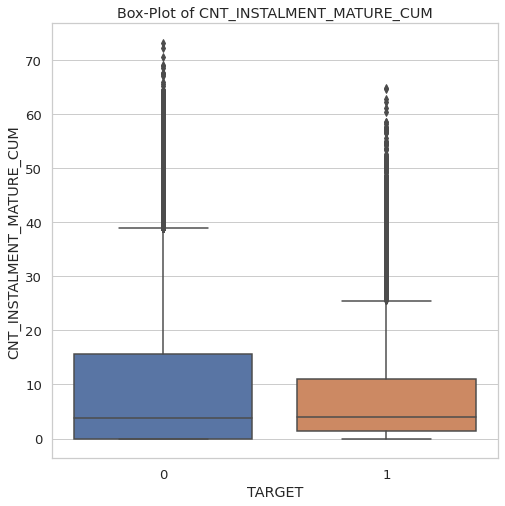

In [ ]:
#The column describes about the average number of installments paid on the previous credits.
plot_continuous_variables(cc_balance_M, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (8,8))

**Observations and Conclusions** <br>
From the above plot, we see a very interesting behaviour. This plot shows that the Non-Defaulters usually had higher range of values for the number of installments paid as compared to Defaulters. This might show the defaulting behaviour, where in the defaulters usually would pay fewer number of installments on their previous credit.

In [ ]:
#shapes:
print(f'numbers of rows and columns of application_train.csv is: {app_train.shape}')
print(f'numbers of rows and columns of application_test.csv is: {app_test.shape}')
print(f'numbers of rows and columns of bureau.csv is: {bureau.shape}')
print(f'numbers of rows and columns of bureau_balance.csv is: {bureau_balance.shape}')
print(f'numbers of rows and columns of POS_Cash_balance.csv is: {POS_CASH_balance.shape}')
print(f'numbers of rows and columns of installments_payments.csv is: {installments_payments.shape}')
print(f'numbers of rows and columns of credit_card_balance.csv is: {creditC_balance.shape}')

numbers of rows and columns of application_train.csv is: (307511, 122)
numbers of rows and columns of application_test.csv is: (48744, 121)
numbers of rows and columns of bureau.csv is: (1716428, 17)
numbers of rows and columns of bureau_balance.csv is: (27299925, 3)
numbers of rows and columns of POS_Cash_balance.csv is: (10001358, 8)
numbers of rows and columns of installments_payments.csv is: (13605401, 8)
numbers of rows and columns of credit_card_balance.csv is: (3840312, 23)
